In [1]:
import requests
import random
import logging
import time
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, chi2_contingency
import os
import io
from google import genai
from dotenv import load_dotenv

DATA_DIR_RAW = os.path.join("..", "..", "data", "raw")
DATA_DIR_PROCESSED = os.path.join("..", "..", "data", "processed")

# 🪵 Logging setup
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

In [26]:
import matplotlib.font_manager as fm
import matplotlib as plt

available_fonts = sorted({f.name for f in fm.fontManager.ttflist})
plt.rcParams['font.family'] = 'Garamond'
plt.rcParams['font.size'] = 14

In [3]:
OUTPUT_NEW_EVENTS_2024 = os.path.join(DATA_DIR_RAW, "NYC_Permitted_Event_Information_-_Historical_20250924.csv")
new_events_2024 = pd.read_csv(OUTPUT_NEW_EVENTS_2024)
new_events_2024.head()

Event ID                                         Event Name  \
0    702878           Street Health Outreach  Wellness Program   
1    806195  Lego Experiential Activation at Vanderbilt Hal...   
2    702875           Street Health Outreach  Wellness Program   
3    793830        EEG-US Open Executive Event at 643 Broadway   
4    797408                      Manhattan SAFE Disposal Event   

          Start Date/Time           End Date/Time  \
0  09/13/2024 10:00:00 AM  09/13/2024 06:00:00 PM   
1  09/16/2024 08:00:00 AM  09/17/2024 11:30:00 PM   
2  09/13/2024 10:00:00 AM  09/13/2024 06:00:00 PM   
3  09/06/2024 07:00:00 PM  09/06/2024 10:00:00 PM   
4  09/22/2024 10:00:00 AM  09/22/2024 04:00:00 PM   

                    Event Agency        Event Type Event Borough  \
0  Street Activity Permit Office      Street Event     Manhattan   
1  Street Activity Permit Office  Production Event     Manhattan   
2  Street Activity Permit Office      Street Event     Manhattan   
3  Street Activity Permit Office  Production Event     Manhattan   
4  Street Activity Permit Office      Street Event     Manhattan   

                                      Event Location Event Street Side  \
0  AMSTERDAM AVENUE between WEST  180 STREET and ...              East   
1  EAST   42 STREET between LEXINGTON AVENUE and ...             North   
2  MT MORRIS PARK WEST between W 124TH STREET and...              West   
3   BROADWAY between BOND STREET and BLEECKER STREET              West   
4  EAST   17 STREET between PARK AVENUE SOUTH and...              Full   

  Street Closure Type Community Board Police Precinct  
0      Curb Lane Only             12,             34,  
1      Curb Lane Only              5,             14,  
2      Curb Lane Only         10, 11,         25, 28,  
3      Curb Lane Only              2,           6, 9,  
4      Curb Lane Only              5,             13,

In [4]:
import pandas as pd

# Example: assume new_events_2024 is your dataframe
# and it has a column 'Event_Location'

new_unique_events = (
    new_events_2024
    .groupby("Event Location", group_keys=False)   # group by location
    .apply(lambda x: x.sample(1, random_state=None))  # randomly pick 1 row per location
    .reset_index(drop=True)
)

new_unique_events


C:\Users\aisha\AppData\Local\Temp\ipykernel_23248\822319817.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1, random_state=None))  # randomly pick 1 row per location


Event ID                           Event Name         Start Date/Time  \
0       782671               New York Lymphoma Walk  06/15/2024 08:30:00 AM   
1       786811                         Shred-A-Thon  06/18/2024 09:00:00 AM   
2       762851                        Passover 2024  03/27/2024 12:00:00 AM   
3       775400         92 Street Greenmarket Sunday  11/24/2024 08:00:00 AM   
4       759161      FuJian Tangtou Asscociation USA  04/23/2024 12:00:00 PM   
...        ...                                  ...                     ...   
1164    813056                            Jacquemus  10/18/2024 07:00:00 AM   
1165    804347                        Poppi Pop Ups  08/31/2024 07:00:00 AM   
1166    758747                              R2//NYC  09/15/2024 04:00:00 PM   
1167    796451                            WomenWalk  07/20/2024 02:00:00 PM   
1168    812156  Celebrating Science Benefit Lecture  10/30/2024 05:30:00 PM   

               End Date/Time                   Event Agency  \
0     06/15/2024 02:00:00 PM              Police Department   
1     06/18/2024 12:00:00 PM  Street Activity Permit Office   
2     04/25/2024 11:59:00 PM  Street Activity Permit Office   
3     11/24/2024 05:00:00 PM  Street Activity Permit Office   
4     04/23/2024 02:00:00 PM              Police Department   
...                      ...                            ...   
1164  10/20/2024 04:00:00 PM  Street Activity Permit Office   
1165  09/10/2024 11:30:00 PM  Street Activity Permit Office   
1166  09/15/2024 05:00:00 PM              Police Department   
1167  07/20/2024 07:00:00 PM              Police Department   
1168  10/30/2024 09:30:00 PM  Street Activity Permit Office   

                Event Type Event Borough  \
0                   Parade     Manhattan   
1             Street Event     Manhattan   
2          Religious Event     Manhattan   
3           Farmers Market     Manhattan   
4          Religious Event     Manhattan   
...                    ...           ...   
1164          Street Event     Manhattan   
1165          Street Event     Manhattan   
1166  Athletic Race / Tour     Manhattan   
1167                Parade     Manhattan   
1168      Production Event     Manhattan   

                                         Event Location Event Street Side  \
0     0 SOUTH STREET PIER   16, SOUTH STREET between...               NaN   
1     1 AVENUE between EAST   67 STREET and EAST   6...              East   
2     1 AVENUE between EAST   89 STREET and EAST   9...              West   
3     1 AVENUE between EAST   92 STREET and EAST   9...              East   
4     1 ELDRIDGE STREET,1  ELDRIDGE STREET, DIVISION...               NaN   
...                                                 ...               ...   
1164  WOOSTER STREET between SPRING STREET and BROOM...             South   
1165  WOOSTER STREET between SPRING STREET and PRINC...              West   
1166  Washington Bridge: Washington Bridge , CABRINI...               NaN   
1167  Washington Square Park: Fountain Plaza , UNIVE...               NaN   
1168  YORK AVENUE between EAST   64 STREET and EAST ...              East   

                 Street Closure Type  Community Board  \
0                Full Street Closure               1,   
1                     Curb Lane Only               8,   
2                     Curb Lane Only               8,   
3     Sidewalk and Curb Lane Closure               8,   
4                Full Street Closure               3,   
...                              ...              ...   
1164  Sidewalk and Curb Lane Closure               2,   
1165  Sidewalk and Curb Lane Closure               2,   
1166             Full Street Closure  12, 4, 5, 7, 9,   
1167             Full Street Closure            2, 5,   
1168                  Curb Lane Only               8,   

                          Police Precinct  
0                                      1,  
1                                     19,  
2                            

In [6]:
import pandas as pd
import os
import json
import time
from geopy.geocoders import Nominatim
from google import genai
from dotenv import load_dotenv
from geopy.extra.rate_limiter import RateLimiter

# --- 1. SETUP ---
try:
    # genai.configure(api_key=os.environ["GEMINI_API_KEY"])
    # ai_client = genai.GenerativeModel('gemini-pro')
    ai_client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))


    print("Gemini AI client configured successfully.")
except (KeyError, TypeError):
    print("Error: GEMINI_API_KEY not found in environment variables.")
    exit()

# Configure geopy
geolocator = Nominatim(user_agent="geopy-batch-geocoder")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# --- 2. LOAD DATA ---
try:
    df = pd.read_csv('../../data/raw/new_unique_events.csv')
    # Initialize lat/lon columns
    df['latitude'] = None
    df['longitude'] = None
    print(f"Successfully loaded 'new_unique_events.csv' with {len(df)} rows.")
except FileNotFoundError:
    print("Error: Could not find 'new_unique_events.csv'.")
    exit()

# --- 3. FIRST PASS: GEOCODE WITH GEOPY ---
print("\n--- Starting Pass 1: Geocoding with Geopy ---")
failed_locations = []

for index, row in df.iterrows():
    try:
        main_location = str(row['Event Location']).split(' between ')[0].split(' and ')[0].strip()
        full_address = f"{main_location}, {row['Event Borough']}, NY"
        
        location_data = geocode(full_address)
        
        if location_data:
            df.at[index, 'latitude'] = location_data.latitude
            df.at[index, 'longitude'] = location_data.longitude
            print(f"✅ Geopy SUCCESS for: {full_address}")
        else:
            print(f"🤔 Geopy FAILED for: {full_address}")
            # Add the full address and original index to the list of failures
            failed_locations.append({'index': index, 'address': full_address})
            
    except Exception as e:
        print(f"Geopy error for row {index}: {e}")
        failed_locations.append({'index': index, 'address': full_address})

print(f"\nGeopy pass complete. {len(failed_locations)} locations failed and will be sent to Gemini.")

# --- 4. SECOND PASS: BATCH GEOCODE FAILED LOCATIONS WITH GEMINI ---
if failed_locations:
    print("\n--- Starting Pass 2: Batch Geocoding with Gemini ---")

    # Create a numbered list of addresses for the prompt
    address_list_for_prompt = "\n".join([f"{i+1}. \"{item['address']}\"" for i, item in enumerate(failed_locations)])

    # This prompt is critical for getting structured JSON back
    batch_prompt = f"""
    You are an expert geocoding assistant.
    For each numbered location in the list below, provide its latitude and longitude.
    Return your response as a single, valid JSON object.
    The JSON object should have the original address string as the key, and the value should be another object containing "latitude" and "longitude".
    If you cannot find coordinates for an address, use a value of null.

    Here are the locations:
    {address_list_for_prompt}

    Do not include any text, explanations, or markdown formatting like ```json before or after the JSON object.
    """

    try:
        print("Sending single batch request to Gemini API...")
        # response = ai_client.generate_content(batch_prompt)
        response = ai_client.models.generate_content(
            model = 'gemini-2.5-flash',
            contents = batch_prompt
        )

        
        # Clean up the response to ensure it's valid JSON
        json_text = response.text.strip().replace('```json', '').replace('```', '')
        
        # Parse the JSON response
        coordinates_map = json.loads(json_text)
        print("Successfully parsed JSON response from Gemini.")

        # Update the DataFrame with the results from Gemini
        for item in failed_locations:
            address = item['address']
            if address in coordinates_map and coordinates_map[address]:
                lat = coordinates_map[address].get('latitude')
                lon = coordinates_map[address].get('longitude')
                df.at[item['index'], 'latitude'] = lat
                df.at[item['index'], 'longitude'] = lon
                print(f"🤖 Gemini SUCCESS for: {address}")
            else:
                print(f"❌ Gemini could not find coordinates for: {address}")

    except Exception as e:
        print(f"An error occurred during the Gemini API call or parsing: {e}")

# --- 5. SAVE THE FINAL RESULT ---
output_filename = 'new_unique_events_geocoded.csv'
df.to_csv(output_filename, index=False)

print("\n------------------")
print("✅ Hybrid geocoding complete!")
print(f"Results saved to '{output_filename}'")
print("\nPreview of the final data:")
# Display rows that had missing data to see if they were filled
print(df[df.latitude.notna()].head())

Gemini AI client configured successfully.
Successfully loaded 'new_unique_events.csv' with 1169 rows.

--- Starting Pass 1: Geocoding with Geopy ---
🤔 Geopy FAILED for: 0 SOUTH STREET PIER   16, SOUTH STREET, Manhattan, NY


2025-09-24 12:26:37,155 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=1+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: 1 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 1 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 1 AVENUE, Manhattan, NY


2025-09-24 12:26:40,737 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=1+ELDRIDGE+STREET%2C1++ELDRIDGE+STREET%2C+DIVISION+STREET%2C+Manhattan%2C+NY&format=json&limit=1


🤔 Geopy FAILED for: 1 ELDRIDGE STREET,1  ELDRIDGE STREET, DIVISION STREET, Manhattan, NY


2025-09-24 12:26:42,839 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=10+19+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:26:44,046 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=10+19+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:26:45,235 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('10 19 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()

🤔 Geopy FAILED for: 10 19 STREET, Manhattan, NY


2025-09-24 12:27:03,681 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=10+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:27:04,873 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=10+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:27:06,049 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('10 AVENUE, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
        

🤔 Geopy FAILED for: 10 AVENUE, Manhattan, NY


2025-09-24 12:27:24,492 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=10+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:27:25,685 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=10+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:27:26,892 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('10 AVENUE, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
        

🤔 Geopy FAILED for: 10 AVENUE, Manhattan, NY


2025-09-24 12:27:45,311 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=10+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:27:46,514 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=10+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:27:47,705 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('10 AVENUE, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
        

🤔 Geopy FAILED for: 10 AVENUE, Manhattan, NY


2025-09-24 12:28:06,246 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=10+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:28:07,462 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=10+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:28:08,691 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('10 AVENUE, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
        

🤔 Geopy FAILED for: 10 AVENUE, Manhattan, NY


2025-09-24 12:28:27,111 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=10+EAST+++19+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:28:28,284 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=10+EAST+++19+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: 10 EAST   19 STREET, Manhattan, NY
✅ Geopy SUCCESS for: 11 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 11 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 11 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 11 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 11 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 11 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 11 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 11 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 11 AVENUE, Manhattan, NY
🤔 Geopy FAILED for: 113 BAXTER STREET, BAXTER STREET, Manhattan, NY
✅ Geopy SUCCESS for: 12 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 12 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 12 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 12 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 12 AVENUE, Manhattan, NY
🤔 Geopy FAILED for: 130  LIBERTY STREET, BROADWAY, Manhattan, NY


2025-09-24 12:28:46,466 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=14+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:28:47,646 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=14+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:28:48,839 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('14 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
        

🤔 Geopy FAILED for: 14 STREET, Manhattan, NY


2025-09-24 12:29:07,295 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=143+EAST+++17+STREET%2C+EAST+++17+STREET%2C+Manhattan%2C+NY&format=json&limit=1


🤔 Geopy FAILED for: 143 EAST   17 STREET, EAST   17 STREET, Manhattan, NY
✅ Geopy SUCCESS for: 14TH STREET, Manhattan, NY
✅ Geopy SUCCESS for: 160  CONVENT AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 160 CONVENT AVENUE, Manhattan, NY
🤔 Geopy FAILED for: 17-23 EAST BROADWAY, EAST BROADWAY, Manhattan, NY


2025-09-24 12:29:13,419 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=173+EAST++++3+STREET%2C173+EAST++++3+STREET%2C173+EAST++++3+STREET%2C115+THROOP+AVENUE%2C+AVENUE+A%2C+Manhattan%2C+NY&format=json&limit=1


🤔 Geopy FAILED for: 173 EAST    3 STREET,173 EAST    3 STREET,173 EAST    3 STREET,115 THROOP AVENUE, AVENUE A, Manhattan, NY
✅ Geopy SUCCESS for: 2 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 2 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 208  WEST   13 STREET, Manhattan, NY
✅ Geopy SUCCESS for: 240  EAST  109 STREET, Manhattan, NY


2025-09-24 12:29:19,660 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=240+WEST+++47+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: 240 WEST   47 STREET, Manhattan, NY


2025-09-24 12:29:21,361 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=25+BROADWAY%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: 25 BROADWAY, Manhattan, NY


2025-09-24 12:29:23,370 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=3+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: 3 AVENUE, Manhattan, NY


2025-09-24 12:29:25,472 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=3+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: 3 AVENUE, Manhattan, NY


2025-09-24 12:29:27,444 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=3+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: 3 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 3 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 3 AVENUE, Manhattan, NY


2025-09-24 12:29:31,479 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=31+EAST+++17+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:29:32,677 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=31+EAST+++17+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:29:33,894 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('31 EAST   17 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response

🤔 Geopy FAILED for: 31 EAST   17 STREET, Manhattan, NY
🤔 Geopy FAILED for: 315 EAST   46 STREET, EAST   46 STREET, Manhattan, NY


2025-09-24 12:29:53,331 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=328+West+WEST+++14+STREET%2C+W+14+ST%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:29:54,657 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=328+West+WEST+++14+STREET%2C+W+14+ST%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:29:55,871 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('328 West WEST   14 STREET, W 14 ST, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connection

🤔 Geopy FAILED for: 328 West WEST   14 STREET, W 14 ST, Manhattan, NY
✅ Geopy SUCCESS for: 340 CONVENT AVENUE, Manhattan, NY
🤔 Geopy FAILED for: 350 CABRINI BOULEVARD, CABRINI BOULEVARD, Manhattan, NY
✅ Geopy SUCCESS for: 384 DYCKMAN STREET, Manhattan, NY
✅ Geopy SUCCESS for: 4 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 4 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 4 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 42  44 STREET, Manhattan, NY


2025-09-24 12:30:21,132 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=447+EAST++115+STREET%2C+EAST++115+STREET%2C+Manhattan%2C+NY&format=json&limit=1


🤔 Geopy FAILED for: 447 EAST  115 STREET, EAST  115 STREET, Manhattan, NY
🤔 Geopy FAILED for: 46/47 Broadway Pedestrian Plaza (Times Sq): 46/47 Broadway Pedestrian Plaza (Times Sq) BROADWAY, Manhattan, NY


2025-09-24 12:30:24,388 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=47+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:30:25,608 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=47+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:30:26,851 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('47 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
        

🤔 Geopy FAILED for: 47 STREET, Manhattan, NY


2025-09-24 12:30:45,307 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=47+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:30:46,496 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=47+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:30:47,685 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('47 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
        

🤔 Geopy FAILED for: 47 STREET, Manhattan, NY


2025-09-24 12:31:06,050 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=47+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:31:07,240 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=47+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:31:08,446 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('47 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
        

🤔 Geopy FAILED for: 47 STREET, Manhattan, NY


2025-09-24 12:31:26,797 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=47+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:31:27,981 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=47+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:31:29,187 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('47 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
        

🤔 Geopy FAILED for: 47 STREET, Manhattan, NY
🤔 Geopy FAILED for: 473 EAST  115 STREET, EAST  115 STREET, Manhattan, NY
🤔 Geopy FAILED for: 473 EAST  115 STREET, EAST  115 STREET, Manhattan, NY
🤔 Geopy FAILED for: 4862 BROADWAY,4876 BROADWAY, BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: 5 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 5 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 5 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 5 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 5 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 5 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 5 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 5 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 5 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 5 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 5 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 5 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 5 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 5 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 5 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 5 AVENUE, Manhattan, NY
✅ Geopy SUCCES

2025-09-24 12:32:10,657 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=50+WEST+++34+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: 50 WEST   34 STREET, Manhattan, NY


2025-09-24 12:32:12,797 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=50+WEST+++34+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: 50 WEST   34 STREET, Manhattan, NY
🤔 Geopy FAILED for: 560 BROADWAY AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 6 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 6 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 6 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 6 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 6 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 6 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 6 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 6 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 6 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 6 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 6 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 7 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 7 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 7 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 7 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 7 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 7 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 7 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 7 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 7 AVENUE, Man

2025-09-24 12:32:37,063 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=77+WEST++127+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:32:38,274 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=77+WEST++127+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:32:39,482 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('77 WEST  127 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response

🤔 Geopy FAILED for: 77 WEST  127 STREET, Manhattan, NY
✅ Geopy SUCCESS for: 8 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 8 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 8 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 8 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 8 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 8 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 8 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 8 AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: 825 7 AVENUE, 7 AVENUE, Manhattan, NY


2025-09-24 12:33:06,857 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=89++SOUTH+STREET%2C+SOUTH+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:33:08,046 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=89++SOUTH+STREET%2C+SOUTH+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:33:09,281 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('89  SOUTH STREET, SOUTH STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", li

✅ Geopy SUCCESS for: 89  SOUTH STREET, SOUTH STREET, Manhattan, NY
✅ Geopy SUCCESS for: 89 SOUTH STREET, SOUTH STREET, Manhattan, NY


2025-09-24 12:33:20,052 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=89+SOUTH+STREET%2C+SOUTH+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:33:21,265 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=89+SOUTH+STREET%2C+SOUTH+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:33:22,439 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('89 SOUTH STREET, SOUTH STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 

🤔 Geopy FAILED for: 89 SOUTH STREET, SOUTH STREET, Manhattan, NY


2025-09-24 12:33:41,028 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=89+South+Street+PIER+++17%2C+SOUTH+STREET%2C+Manhattan%2C+NY&format=json&limit=1


🤔 Geopy FAILED for: 89 South Street PIER   17, SOUTH STREET, Manhattan, NY


2025-09-24 12:33:43,224 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=9+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:33:44,432 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=9+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:33:45,632 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('9 AVENUE, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
           

🤔 Geopy FAILED for: 9 AVENUE, Manhattan, NY


2025-09-24 12:34:04,092 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=9+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:34:05,302 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=9+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:34:06,541 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('9 AVENUE, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
           

🤔 Geopy FAILED for: 9 AVENUE, Manhattan, NY
🤔 Geopy FAILED for: 91 ARDEN STREET, ARDEN STREET, Manhattan, NY
✅ Geopy SUCCESS for: ACADEMY STREET, Manhattan, NY
✅ Geopy SUCCESS for: ADAM CLAYTON POWELL JR BOULEVARD, Manhattan, NY
✅ Geopy SUCCESS for: ADAM CLAYTON POWELL JR BOULEVARD, Manhattan, NY
✅ Geopy SUCCESS for: ADAM CLAYTON POWELL JR BOULEVARD, Manhattan, NY
✅ Geopy SUCCESS for: ADAM CLAYTON POWELL JR BOULEVARD, Manhattan, NY
✅ Geopy SUCCESS for: AMSTERDAM AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: AMSTERDAM AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: AMSTERDAM AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: AMSTERDAM AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: AMSTERDAM AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: AMSTERDAM AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: AMSTERDAM AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: AMSTERDAM AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: AMSTERDAM AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: ASTOR PLACE, Manhattan, NY
✅ Geopy SUCCESS for: AUDUBON AVENUE, Ma

2025-09-24 12:34:47,157 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=AVENUE+OF+THE+AMERICAS%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: AVENUE OF THE AMERICAS, Manhattan, NY


2025-09-24 12:34:48,717 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=AVENUE+OF+THE+AMERICAS%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: AVENUE OF THE AMERICAS, Manhattan, NY
✅ Geopy SUCCESS for: AVENUE OF THE AMERICAS, Manhattan, NY
✅ Geopy SUCCESS for: AVENUE OF THE AMERICAS, Manhattan, NY


2025-09-24 12:34:52,676 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=BANK+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: BANK STREET, Manhattan, NY


2025-09-24 12:34:54,674 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=BATTERY+PLACE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: BATTERY PLACE, Manhattan, NY


2025-09-24 12:34:56,715 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=BATTERY+PLACE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: BATTERY PLACE, Manhattan, NY
✅ Geopy SUCCESS for: BAXTER STREET, Manhattan, NY
✅ Geopy SUCCESS for: BEEKMAN STREET, Manhattan, NY
✅ Geopy SUCCESS for: BLEECKER STREET, Manhattan, NY
✅ Geopy SUCCESS for: BLEECKER STREET, Manhattan, NY
✅ Geopy SUCCESS for: BLEECKER STREET, Manhattan, NY
✅ Geopy SUCCESS for: BLEECKER STREET, Manhattan, NY
✅ Geopy SUCCESS for: BLEECKER STREET, Manhattan, NY
✅ Geopy SUCCESS for: BOGARDUS PLACE, Manhattan, NY
✅ Geopy SUCCESS for: BOND STREET, Manhattan, NY
✅ Geopy SUCCESS for: BOND STREET, Manhattan, NY
✅ Geopy SUCCESS for: BOND STREET, Manhattan, NY
✅ Geopy SUCCESS for: BOND STREET, Manhattan, NY
✅ Geopy SUCCESS for: BOWERY, Manhattan, NY
✅ Geopy SUCCESS for: BOWERY, Manhattan, NY
✅ Geopy SUCCESS for: BRADHURST AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: BROAD STREET, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BR

2025-09-24 12:35:24,016 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=BROADWAY%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY


2025-09-24 12:35:25,656 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=BROADWAY%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY


2025-09-24 12:35:27,711 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=BROADWAY%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY


2025-09-24 12:35:29,675 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=BROADWAY%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY


2025-09-24 12:35:35,707 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=BROADWAY%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY


2025-09-24 12:35:55,770 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=BROADWAY%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY


2025-09-24 12:35:57,656 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=BROADWAY%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: BROOME STREET, Manhattan, NY
✅ Geopy SUCCESS for: BROOME STREET, Manhattan, NY
✅ Geopy SUCCESS for: BROOME STREET, Manhattan, NY
✅ Geopy SUCCESS for: BROOME STREET, Manh

2025-09-24 12:36:22,992 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=Battery+Park%3A+Battery+Park+%2C+RIVER+TERRACE%2C+Manhattan%2C+NY&format=json&limit=1


🤔 Geopy FAILED for: Battery Park: Battery Park , RIVER TERRACE, Manhattan, NY
🤔 Geopy FAILED for: Brooklyn Bridge: Brooklyn Bridge Pedestrian: 1, Manhattan, NY
✅ Geopy SUCCESS for: CANAL STREET, Manhattan, NY
✅ Geopy SUCCESS for: CENTRAL PARK SOUTH, Manhattan, NY
✅ Geopy SUCCESS for: CENTRAL PARK WEST, Manhattan, NY
✅ Geopy SUCCESS for: CENTRAL PARK WEST, Manhattan, NY
✅ Geopy SUCCESS for: CENTRE STREET, Manhattan, NY
✅ Geopy SUCCESS for: CENTRE STREET, Manhattan, NY
✅ Geopy SUCCESS for: CENTRE STREET, Manhattan, NY
✅ Geopy SUCCESS for: CENTRE STREET, Manhattan, NY
✅ Geopy SUCCESS for: CHAMBERS STREET, Manhattan, NY
✅ Geopy SUCCESS for: CHAMBERS STREET, Manhattan, NY
✅ Geopy SUCCESS for: CHAMBERS STREET, Manhattan, NY
✅ Geopy SUCCESS for: CHAMBERS STREET, Manhattan, NY
✅ Geopy SUCCESS for: CHAMBERS STREET, Manhattan, NY
✅ Geopy SUCCESS for: CHAMBERS STREET, Manhattan, NY
✅ Geopy SUCCESS for: CHARLES STREET, Manhattan, NY
✅ Geopy SUCCESS for: CHARLTON STREET, Manhattan, NY
✅ Geopy SUCCE

2025-09-24 12:37:13,023 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++++2+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:37:14,212 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++++2+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:37:15,417 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST    2 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST    2 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST    3 STREET, Manhattan, NY


2025-09-24 12:37:34,844 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++++3+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:37:36,036 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++++3+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST    3 STREET, Manhattan, NY


2025-09-24 12:37:38,228 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++++3+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:37:39,436 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++++3+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:37:40,636 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST    3 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

✅ Geopy SUCCESS for: EAST    3 STREET, Manhattan, NY


2025-09-24 12:37:47,832 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++++3+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST    3 STREET, Manhattan, NY


2025-09-24 12:37:49,953 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++++3+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST    3 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST    4 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST    4 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST    5 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST    6 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST    6 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST    6 STREET, Manhattan, NY


2025-09-24 12:37:58,413 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++++6+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:37:59,601 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++++6+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:38:00,823 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST    6 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

✅ Geopy SUCCESS for: EAST    6 STREET, Manhattan, NY


2025-09-24 12:38:07,885 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++++6+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST    6 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST    7 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST    8 STREET, Manhattan, NY


2025-09-24 12:38:12,075 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++++9+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:38:13,275 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++++9+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:38:14,459 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST    9 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST    9 STREET, Manhattan, NY


2025-09-24 12:38:32,947 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++10+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   10 STREET, Manhattan, NY


2025-09-24 12:38:34,984 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++10+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   10 STREET, Manhattan, NY


2025-09-24 12:38:37,009 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++10+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   10 STREET, Manhattan, NY


2025-09-24 12:38:39,018 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++10+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   10 STREET, Manhattan, NY


2025-09-24 12:38:41,018 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++11+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:38:42,201 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++11+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   11 STREET, Manhattan, NY


2025-09-24 12:38:44,386 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++11+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:38:45,592 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++11+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   11 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   11 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   11 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   11 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   11 STREET, Manhattan, NY


2025-09-24 12:38:51,633 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++13+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   13 STREET, Manhattan, NY


2025-09-24 12:38:53,689 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++13+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   13 STREET, Manhattan, NY


2025-09-24 12:38:55,785 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++14+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   14 STREET, Manhattan, NY


2025-09-24 12:38:57,763 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++14+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   14 STREET, Manhattan, NY


2025-09-24 12:38:59,786 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++16+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   16 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   16 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   16 STREET, Manhattan, NY


2025-09-24 12:39:03,949 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++16+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   16 STREET, Manhattan, NY


2025-09-24 12:39:06,038 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++17+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:39:07,235 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++17+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:39:08,467 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   17 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST   17 STREET, Manhattan, NY


2025-09-24 12:39:26,808 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++17+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:39:28,022 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++17+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:39:29,217 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   17 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST   17 STREET, Manhattan, NY


2025-09-24 12:39:47,756 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++17+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:39:48,967 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++17+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:39:50,171 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   17 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST   17 STREET, Manhattan, NY


2025-09-24 12:40:08,715 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++17+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:40:09,897 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++17+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:40:11,073 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   17 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST   17 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   18 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   18 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   18 STREET, Manhattan, NY


2025-09-24 12:40:32,515 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++20+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:40:33,741 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++20+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:40:34,945 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   20 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

✅ Geopy SUCCESS for: EAST   20 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   21 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   22 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   22 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   23 STREET, Manhattan, NY


2025-09-24 12:40:46,363 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++24+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:40:47,589 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++24+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   24 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   25 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   26 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   26 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   26 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   26 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   28 STREET, Manhattan, NY


2025-09-24 12:40:55,754 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++36+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:40:56,929 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++36+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:40:58,136 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   36 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

✅ Geopy SUCCESS for: EAST   36 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   37 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   37 STREET, Manhattan, NY


2025-09-24 12:41:17,107 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++37+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   37 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   37 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   37 STREET, Manhattan, NY


2025-09-24 12:41:20,966 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++37+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   37 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   38 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   38 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   38 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   38 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   38 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   38 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   38 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   40 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   40 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   41 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   41 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   41 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   41 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   42 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   42 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   42 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   42 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   42 STREET, Manhatt

2025-09-24 12:41:42,517 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++44+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:41:43,718 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++44+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:41:45,033 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   44 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

✅ Geopy SUCCESS for: EAST   44 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   45 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   45 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   45 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   45 STREET, Manhattan, NY


2025-09-24 12:42:07,214 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++46+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   46 STREET, Manhattan, NY


2025-09-24 12:42:09,142 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++47+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   47 STREET, Manhattan, NY


2025-09-24 12:42:11,313 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++47+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:42:12,508 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++47+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:42:13,735 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   47 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

✅ Geopy SUCCESS for: EAST   47 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   48 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   49 STREET, Manhattan, NY


2025-09-24 12:42:24,121 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++49+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   49 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   49 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   50 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   51 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   51 STREET, Manhattan, NY


2025-09-24 12:42:30,080 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++51+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:42:31,275 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++51+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   51 STREET, Manhattan, NY


2025-09-24 12:42:33,140 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++51+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:42:34,360 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++51+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:42:35,581 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   51 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

✅ Geopy SUCCESS for: EAST   51 STREET, Manhattan, NY


2025-09-24 12:42:43,884 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++52+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   52 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   52 STREET, Manhattan, NY


2025-09-24 12:42:47,218 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++52+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:42:48,418 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++52+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:42:49,596 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   52 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST   52 STREET, Manhattan, NY


2025-09-24 12:43:08,025 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++52+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:43:09,207 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++52+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:43:10,412 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   52 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

✅ Geopy SUCCESS for: EAST   52 STREET, Manhattan, NY


2025-09-24 12:43:26,089 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++53+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:43:27,452 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++53+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:43:28,680 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   53 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

✅ Geopy SUCCESS for: EAST   53 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   54 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   54 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   54 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   54 STREET, Manhattan, NY


2025-09-24 12:43:48,415 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++54+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   54 STREET, Manhattan, NY


2025-09-24 12:43:50,264 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++55+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   55 STREET, Manhattan, NY


2025-09-24 12:43:52,365 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++56+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   56 STREET, Manhattan, NY


2025-09-24 12:43:54,249 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++57+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   57 STREET, Manhattan, NY


2025-09-24 12:43:56,274 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++57+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:43:57,479 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++57+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   57 STREET, Manhattan, NY


2025-09-24 12:43:59,409 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++57+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:44:00,610 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++57+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   57 STREET, Manhattan, NY


2025-09-24 12:44:02,506 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++58+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   58 STREET, Manhattan, NY


2025-09-24 12:44:04,474 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++59+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   59 STREET, Manhattan, NY


2025-09-24 12:44:06,465 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++59+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   59 STREET, Manhattan, NY


2025-09-24 12:44:08,476 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++60+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   60 STREET, Manhattan, NY


2025-09-24 12:44:10,506 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++60+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   60 STREET, Manhattan, NY


2025-09-24 12:44:12,474 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++60+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   60 STREET, Manhattan, NY


2025-09-24 12:44:14,474 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++60+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:44:15,675 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++60+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   60 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   61 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   61 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   61 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   61 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   63 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   63 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   63 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   65 STREET, Manhattan, NY


2025-09-24 12:44:25,670 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++66+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   66 STREET, Manhattan, NY


2025-09-24 12:44:27,537 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++66+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   66 STREET, Manhattan, NY


2025-09-24 12:44:29,623 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++68+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:44:30,850 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++68+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:44:32,044 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   68 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

✅ Geopy SUCCESS for: EAST   68 STREET, Manhattan, NY


2025-09-24 12:44:39,220 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++68+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:44:40,428 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++68+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:44:41,615 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   68 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

✅ Geopy SUCCESS for: EAST   68 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   68 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   68 STREET, Manhattan, NY


2025-09-24 12:44:54,209 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++68+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:44:55,418 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++68+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   68 STREET, Manhattan, NY


2025-09-24 12:44:57,642 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++68+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:44:58,845 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++68+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:45:00,018 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   68 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST   68 STREET, Manhattan, NY


2025-09-24 12:45:18,500 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++69+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   69 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   70 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   70 STREET, Manhattan, NY


2025-09-24 12:45:22,542 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++71+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:45:23,770 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++71+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:45:25,067 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   71 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST   71 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   71 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   72 STREET, Manhattan, NY


2025-09-24 12:45:45,639 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++73+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:45:46,841 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++73+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:45:48,037 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   73 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

✅ Geopy SUCCESS for: EAST   73 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   73 STREET, Manhattan, NY


2025-09-24 12:45:56,427 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++73+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:45:57,634 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++73+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:45:58,829 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   73 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

✅ Geopy SUCCESS for: EAST   73 STREET, Manhattan, NY


2025-09-24 12:46:14,527 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++75+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:46:15,775 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++75+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:46:16,994 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   75 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST   75 STREET, Manhattan, NY


2025-09-24 12:46:35,404 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++75+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:46:36,602 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++75+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:46:37,823 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   75 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST   75 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   76 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   77 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   80 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   82 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   84 STREET, Manhattan, NY


2025-09-24 12:47:01,165 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++85+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   85 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   86 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   88 STREET, Manhattan, NY


2025-09-24 12:47:05,389 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++89+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   89 STREET, Manhattan, NY


2025-09-24 12:47:07,612 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++89+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:47:08,811 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++89+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:47:09,995 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   89 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

✅ Geopy SUCCESS for: EAST   89 STREET, Manhattan, NY


2025-09-24 12:47:26,923 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++90+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:47:28,138 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++90+STREET%2C+Manhattan%2C+NY&format=json&limit=1


🤔 Geopy FAILED for: EAST   90 STREET, Manhattan, NY
🤔 Geopy FAILED for: EAST   90 STREET, Manhattan, NY


2025-09-24 12:47:31,580 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++90+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:47:32,789 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++90+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:47:33,970 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   90 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST   90 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   91 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   91 STREET, Manhattan, NY


2025-09-24 12:47:54,480 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++92+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:47:55,696 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++92+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:47:56,913 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST   92 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST   92 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   92 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   92 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   97 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   99 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST   99 STREET, Manhattan, NY


2025-09-24 12:48:20,286 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+++99+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST   99 STREET, Manhattan, NY


2025-09-24 12:48:22,250 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++100+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST  100 STREET, Manhattan, NY


2025-09-24 12:48:24,370 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++100+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST  100 STREET, Manhattan, NY


2025-09-24 12:48:26,288 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++100+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST  100 STREET, Manhattan, NY


2025-09-24 12:48:28,301 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++101+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:48:29,502 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++101+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:48:30,701 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  101 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  101 STREET, Manhattan, NY


2025-09-24 12:48:49,270 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++101+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:48:50,461 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++101+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:48:51,666 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  101 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  101 STREET, Manhattan, NY


2025-09-24 12:49:10,118 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++101+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:49:11,317 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++101+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:49:12,499 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  101 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  101 STREET, Manhattan, NY


2025-09-24 12:49:31,030 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++104+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:49:32,242 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++104+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:49:33,438 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  104 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  104 STREET, Manhattan, NY


2025-09-24 12:49:51,885 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++104+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:49:53,088 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++104+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:49:54,401 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  104 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  104 STREET, Manhattan, NY


2025-09-24 12:50:12,805 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++104+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:50:14,005 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++104+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:50:15,192 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  104 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  104 STREET, Manhattan, NY


2025-09-24 12:50:33,591 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++104+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:50:34,771 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++104+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:50:35,954 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  104 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  104 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST  105 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST  106 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST  106 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST  106 STREET, Manhattan, NY


2025-09-24 12:50:58,479 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++107+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:50:59,668 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++107+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:51:00,895 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  107 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  107 STREET, Manhattan, NY


2025-09-24 12:51:19,322 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++109+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST  109 STREET, Manhattan, NY


2025-09-24 12:51:21,449 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++109+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST  109 STREET, Manhattan, NY


2025-09-24 12:51:23,442 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++110+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:51:24,659 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++110+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:51:25,857 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  110 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

✅ Geopy SUCCESS for: EAST  110 STREET, Manhattan, NY


2025-09-24 12:51:35,454 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++111+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:51:36,659 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++111+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:51:37,861 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  111 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  111 STREET, Manhattan, NY


2025-09-24 12:51:56,460 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++111+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:51:57,658 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++111+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:51:58,862 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  111 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  111 STREET, Manhattan, NY


2025-09-24 12:52:17,254 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++111+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:52:18,471 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++111+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:52:19,670 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  111 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  111 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST  113 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST  113 STREET, Manhattan, NY


2025-09-24 12:52:40,146 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++114+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST  114 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST  115 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST  115 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST  115 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST  115 STREET, Manhattan, NY


2025-09-24 12:52:46,264 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++116+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:52:47,465 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++116+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:52:48,658 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  116 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  116 STREET, Manhattan, NY


2025-09-24 12:53:07,158 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++116+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:53:08,376 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++116+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:53:09,596 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  116 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  116 STREET, Manhattan, NY


2025-09-24 12:53:28,174 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++116+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:53:29,387 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++116+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:53:30,585 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  116 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  116 STREET, Manhattan, NY


2025-09-24 12:53:49,010 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++116+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:53:50,211 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++116+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:53:51,400 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  116 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  116 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST  117 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST  117 STREET, Manhattan, NY


2025-09-24 12:54:11,952 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++118+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:54:13,136 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++118+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:54:14,334 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  118 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  118 STREET, Manhattan, NY


2025-09-24 12:54:33,731 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++118+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:54:34,912 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++118+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:54:36,211 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  118 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  118 STREET, Manhattan, NY


2025-09-24 12:54:54,576 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++119+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:54:55,790 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++119+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:54:56,969 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  119 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  119 STREET, Manhattan, NY


2025-09-24 12:55:15,414 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++120+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:55:16,614 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++120+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:55:17,812 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  120 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  120 STREET, Manhattan, NY


2025-09-24 12:55:36,686 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++120+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:55:37,882 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++120+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:55:39,089 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  120 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  120 STREET, Manhattan, NY


2025-09-24 12:55:57,600 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++120+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:55:58,806 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++120+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:56:00,000 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  120 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  120 STREET, Manhattan, NY


2025-09-24 12:56:18,455 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++123+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:56:19,650 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++123+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:56:20,846 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  123 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  123 STREET, Manhattan, NY


2025-09-24 12:56:39,547 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++123+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:56:40,756 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++123+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:56:41,944 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  123 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  123 STREET, Manhattan, NY


2025-09-24 12:57:00,328 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++124+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:57:01,518 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++124+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:57:02,714 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  124 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  124 STREET, Manhattan, NY


2025-09-24 12:57:21,106 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++125+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:57:22,433 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++125+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:57:23,646 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  125 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  125 STREET, Manhattan, NY


2025-09-24 12:57:42,126 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++128+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:57:43,328 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++128+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:57:44,549 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  128 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  128 STREET, Manhattan, NY


2025-09-24 12:58:02,965 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++129+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:58:04,161 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++129+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:58:05,388 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  129 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  129 STREET, Manhattan, NY


2025-09-24 12:58:23,878 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++129+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:58:25,081 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++129+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:58:26,265 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  129 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  129 STREET, Manhattan, NY


2025-09-24 12:58:44,697 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++130+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:58:46,022 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST++130+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 12:58:47,247 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('EAST  130 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: EAST  130 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST 50TH STREET, Manhattan, NY


2025-09-24 12:59:06,554 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=EAST+63+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: EAST 63 STREET, Manhattan, NY
✅ Geopy SUCCESS for: EAST BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: EAST END AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: EAST HOUSTON STREET, Manhattan, NY
✅ Geopy SUCCESS for: EDGECOMBE AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: EDGECOMBE AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: EDGECOMBE AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: ELDRIDGE STREET, Manhattan, NY
✅ Geopy SUCCESS for: ELDRIDGE STREET, Manhattan, NY
✅ Geopy SUCCESS for: ELDRIDGE STREET, Manhattan, NY
✅ Geopy SUCCESS for: ELIZABETH STREET, Manhattan, NY
✅ Geopy SUCCESS for: ELIZABETH STREET, Manhattan, NY
✅ Geopy SUCCESS for: EXCHANGE PLACE, Manhattan, NY
✅ Geopy SUCCESS for: FIFTH AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: FIFTH AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: FORSYTH STREET, Manhattan, NY
✅ Geopy SUCCESS for: FORSYTH STREET, Manhattan, NY
✅ Geopy SUCCESS for: FORSYTH STREET, Manhattan, NY
✅ Geopy SUCCESS for: FORT WASHINGTON AVENUE, Manhattan, NY
✅ Geopy S

2025-09-24 13:00:06,610 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=HARRISON+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: HARRISON STREET, Manhattan, NY
✅ Geopy SUCCESS for: HARRISON STREET, Manhattan, NY
✅ Geopy SUCCESS for: HENRY STREET, Manhattan, NY
✅ Geopy SUCCESS for: HESTER STREET, Manhattan, NY
✅ Geopy SUCCESS for: HESTER STREET, Manhattan, NY
✅ Geopy SUCCESS for: HESTER STREET, Manhattan, NY
✅ Geopy SUCCESS for: HESTER STREET, Manhattan, NY
✅ Geopy SUCCESS for: HORATIO STREET, Manhattan, NY


2025-09-24 13:00:15,776 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=HOWARD+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: HOWARD STREET, Manhattan, NY
✅ Geopy SUCCESS for: HUDSON BLVD EAST, Manhattan, NY
✅ Geopy SUCCESS for: HUDSON BLVD EAST, Manhattan, NY
✅ Geopy SUCCESS for: HUDSON STREET, Manhattan, NY
✅ Geopy SUCCESS for: HUDSON STREET, Manhattan, NY
✅ Geopy SUCCESS for: HUDSON STREET, Manhattan, NY
✅ Geopy SUCCESS for: HUDSON STREET, Manhattan, NY


2025-09-24 13:00:23,634 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=HUDSON+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: HUDSON STREET, Manhattan, NY


2025-09-24 13:00:25,635 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=INDIAN+ROAD%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: INDIAN ROAD, Manhattan, NY
✅ Geopy SUCCESS for: IRVING PLACE, Manhattan, NY
✅ Geopy SUCCESS for: ISHAM STREET, Manhattan, NY
✅ Geopy SUCCESS for: ISHAM STREET, Manhattan, NY
✅ Geopy SUCCESS for: JAY STREET, Manhattan, NY
✅ Geopy SUCCESS for: JEFFERSON STREET, Manhattan, NY
✅ Geopy SUCCESS for: JEFFERSON STREET, Manhattan, NY


2025-09-24 13:00:33,616 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=JOHN+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: JOHN STREET, Manhattan, NY
✅ Geopy SUCCESS for: KENMARE STREET, Manhattan, NY
✅ Geopy SUCCESS for: LA SALLE STREET, Manhattan, NY
✅ Geopy SUCCESS for: LAFAYETTE STREET, Manhattan, NY
✅ Geopy SUCCESS for: LAFAYETTE STREET, Manhattan, NY
✅ Geopy SUCCESS for: LAFAYETTE STREET, Manhattan, NY
✅ Geopy SUCCESS for: LAFAYETTE STREET, Manhattan, NY
✅ Geopy SUCCESS for: LAFAYETTE STREET, Manhattan, NY


2025-09-24 13:00:42,977 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=LAFAYETTE+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: LAFAYETTE STREET, Manhattan, NY
✅ Geopy SUCCESS for: LAFAYETTE STREET, Manhattan, NY
✅ Geopy SUCCESS for: LAFAYETTE STREET, Manhattan, NY


2025-09-24 13:00:46,708 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=LAFAYETTE+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: LAFAYETTE STREET, Manhattan, NY


2025-09-24 13:00:48,701 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=LAFAYETTE+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: LAFAYETTE STREET, Manhattan, NY
✅ Geopy SUCCESS for: LAFAYETTE STREET, Manhattan, NY
✅ Geopy SUCCESS for: LAFAYETTE STREET, Manhattan, NY
✅ Geopy SUCCESS for: LAFAYETTE STREET, Manhattan, NY
✅ Geopy SUCCESS for: LAFAYETTE STREET, Manhattan, NY


2025-09-24 13:00:54,843 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=LAGUARDIA+PLACE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: LAGUARDIA PLACE, Manhattan, NY


2025-09-24 13:00:56,379 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=LAIGHT+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: LAIGHT STREET, Manhattan, NY


2025-09-24 13:00:58,310 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=LASALLE+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: LASALLE STREET, Manhattan, NY


2025-09-24 13:01:00,341 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=LENOX+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: LENOX AVENUE, Manhattan, NY


2025-09-24 13:01:02,486 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=LENOX+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: LENOX AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: LEROY STREET, Manhattan, NY
✅ Geopy SUCCESS for: LEXINGTON AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: LEXINGTON AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: LEXINGTON AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: LEXINGTON AVENUE, Manhattan, NY


2025-09-24 13:01:09,916 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=LEXINGTON+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: LEXINGTON AVENUE, Manhattan, NY


2025-09-24 13:01:11,566 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=LEXINGTON+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: LEXINGTON AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: LEXINGTON AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: LEXINGTON AVENUE, Manhattan, NY


2025-09-24 13:01:15,632 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=LEXINGTON+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: LEXINGTON AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: LEXINGTON AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: LEXINGTON AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: LEXINGTON AVENUE, Manhattan, NY


2025-09-24 13:01:20,924 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=LEXINGTON+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: LEXINGTON AVENUE, Manhattan, NY


2025-09-24 13:01:22,583 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=LIBERTY+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: LIBERTY STREET, Manhattan, NY
✅ Geopy SUCCESS for: LIBERTY STREET, Manhattan, NY
✅ Geopy SUCCESS for: LIBERTY STREET, Manhattan, NY
✅ Geopy SUCCESS for: LIBERTY STREET, Manhattan, NY
✅ Geopy SUCCESS for: LIBERTY STREET, Manhattan, NY
✅ Geopy SUCCESS for: LIBERTY STREET, Manhattan, NY


2025-09-24 13:01:29,995 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=LITTLE+WEST+++12+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:01:31,179 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=LITTLE+WEST+++12+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:01:32,361 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('LITTLE WEST   12 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request


🤔 Geopy FAILED for: LITTLE WEST   12 STREET, Manhattan, NY


2025-09-24 13:01:50,854 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=LITTLE+WEST+++12+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:01:52,058 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=LITTLE+WEST+++12+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:01:53,250 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('LITTLE WEST   12 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request


🤔 Geopy FAILED for: LITTLE WEST   12 STREET, Manhattan, NY
✅ Geopy SUCCESS for: LUDLOW STREET, Manhattan, NY
✅ Geopy SUCCESS for: LUDLOW STREET, Manhattan, NY
✅ Geopy SUCCESS for: MACDOUGAL STREET, Manhattan, NY
✅ Geopy SUCCESS for: MADISON AVENUE, Manhattan, NY


2025-09-24 13:02:15,887 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=MADISON+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: MADISON AVENUE, Manhattan, NY


2025-09-24 13:02:17,517 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=MADISON+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: MADISON AVENUE, Manhattan, NY


2025-09-24 13:02:19,612 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=MADISON+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: MADISON AVENUE, Manhattan, NY


2025-09-24 13:02:21,537 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=MADISON+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: MADISON AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: MADISON AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: MADISON AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: MADISON AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: MADISON AVENUE, Manhattan, NY


2025-09-24 13:02:27,664 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=MADISON+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: MADISON AVENUE, Manhattan, NY


2025-09-24 13:02:29,674 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=MADISON+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: MADISON AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: MADISON AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: MADISON AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: MADISON AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: MADISON AVENUE, Manhattan, NY


2025-09-24 13:02:35,636 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=MADISON+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: MADISON AVENUE, Manhattan, NY


2025-09-24 13:02:37,629 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=MADISON+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: MADISON AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: MADISON STREET, Manhattan, NY
✅ Geopy SUCCESS for: MADISON STREET, Manhattan, NY
✅ Geopy SUCCESS for: MAIDEN LANE, Manhattan, NY
🤔 Geopy FAILED for: MAJOR DEEGAN, Manhattan, NY
✅ Geopy SUCCESS for: MANHATTAN AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: MERCER STREET, Manhattan, NY
✅ Geopy SUCCESS for: MERCER STREET, Manhattan, NY
✅ Geopy SUCCESS for: MERCER STREET, Manhattan, NY
✅ Geopy SUCCESS for: MERCER STREET, Manhattan, NY
✅ Geopy SUCCESS for: MERCER STREET, Manhattan, NY
✅ Geopy SUCCESS for: MERCER STREET, Manhattan, NY
✅ Geopy SUCCESS for: MERCER STREET, Manhattan, NY
✅ Geopy SUCCESS for: MERCER STREET, Manhattan, NY
✅ Geopy SUCCESS for: MILL LANE, Manhattan, NY
✅ Geopy SUCCESS for: MORNINGSIDE AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: MORNINGSIDE AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: MORNINGSIDE AVENUE, Manhattan, NY


2025-09-24 13:02:56,931 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=MORNINGSIDE+DRIVE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: MORNINGSIDE DRIVE, Manhattan, NY


2025-09-24 13:02:58,319 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=MORRIS+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: MORRIS STREET, Manhattan, NY
✅ Geopy SUCCESS for: MOTT STREET, Manhattan, NY
✅ Geopy SUCCESS for: MOTT STREET, Manhattan, NY
✅ Geopy SUCCESS for: MOTT STREET, Manhattan, NY
✅ Geopy SUCCESS for: MOTT STREET, Manhattan, NY
✅ Geopy SUCCESS for: MOTT STREET, Manhattan, NY
✅ Geopy SUCCESS for: MOTT STREET, Manhattan, NY
✅ Geopy SUCCESS for: MOTT STREET, Manhattan, NY
✅ Geopy SUCCESS for: MOTT STREET, Manhattan, NY
✅ Geopy SUCCESS for: MOTT STREET, Manhattan, NY
✅ Geopy SUCCESS for: MOUNT CARMEL PLACE, Manhattan, NY
✅ Geopy SUCCESS for: MOUNT MORRIS PARK WEST, Manhattan, NY
✅ Geopy SUCCESS for: MOUNT MORRIS PARK WEST, Manhattan, NY
✅ Geopy SUCCESS for: MOUNT MORRIS PARK WEST, Manhattan, NY
✅ Geopy SUCCESS for: MT MORRIS PARK WEST, Manhattan, NY


2025-09-24 13:03:14,555 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=MULBERRY+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: MULBERRY STREET, Manhattan, NY
✅ Geopy SUCCESS for: MULBERRY STREET, Manhattan, NY
✅ Geopy SUCCESS for: MULBERRY STREET, Manhattan, NY
✅ Geopy SUCCESS for: MULBERRY STREET, Manhattan, NY
✅ Geopy SUCCESS for: MULBERRY STREET, Manhattan, NY
✅ Geopy SUCCESS for: MULBERRY STREET, Manhattan, NY
✅ Geopy SUCCESS for: MULBERRY STREET, Manhattan, NY
🤔 Geopy FAILED for: Marcus Garvey Park: Marcus Garvey Park ,Marcus Garvey Park: Marcus Garvey Park , WEST  124 STREET, Manhattan, NY
✅ Geopy SUCCESS for: NAGLE AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: NORFOLK STREET, Manhattan, NY
✅ Geopy SUCCESS for: NORFOLK STREET, Manhattan, NY
✅ Geopy SUCCESS for: NORTH END AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: NORTH MOORE STREET, Manhattan, NY
✅ Geopy SUCCESS for: OLD BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: ORCHARD STREET, Manhattan, NY


2025-09-24 13:03:30,661 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=ORCHARD+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: ORCHARD STREET, Manhattan, NY


2025-09-24 13:03:32,535 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=ORCHARD+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: ORCHARD STREET, Manhattan, NY


2025-09-24 13:03:34,541 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=PARK+AVENUE+SOUTH%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: PARK AVENUE SOUTH, Manhattan, NY
✅ Geopy SUCCESS for: PARK AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: PARK AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: PARK AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: PARK AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: PARK AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: PARK AVENUE, Manhattan, NY


2025-09-24 13:03:42,688 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=PARK+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: PARK AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: PELL STREET, Manhattan, NY
✅ Geopy SUCCESS for: PINE STREET, Manhattan, NY
✅ Geopy SUCCESS for: PINE STREET, Manhattan, NY
✅ Geopy SUCCESS for: PINE STREET, Manhattan, NY
✅ Geopy SUCCESS for: PITT STREET, Manhattan, NY
✅ Geopy SUCCESS for: PLEASANT AVENUE, Manhattan, NY


2025-09-24 13:03:50,841 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=PLEASANT+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: PLEASANT AVENUE, Manhattan, NY


2025-09-24 13:03:52,462 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=PRINCE+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: PRINCE STREET, Manhattan, NY


2025-09-24 13:03:54,649 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=PRINCE+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: PRINCE STREET, Manhattan, NY


2025-09-24 13:03:56,664 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=PRINCE+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: PRINCE STREET, Manhattan, NY
✅ Geopy SUCCESS for: RIVERSIDE DRIVE, Manhattan, NY
✅ Geopy SUCCESS for: RIVERSIDE DRIVE, Manhattan, NY


2025-09-24 13:04:00,744 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=RIVERSIDE+DRIVE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: RIVERSIDE DRIVE, Manhattan, NY
✅ Geopy SUCCESS for: RIVERSIDE DRIVE, Manhattan, NY
✅ Geopy SUCCESS for: RIVERSIDE DRIVE, Manhattan, NY


2025-09-24 13:04:04,553 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=ROSE+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: ROSE STREET, Manhattan, NY


2025-09-24 13:04:06,479 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=SAINT+NICHOLAS+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: SAINT NICHOLAS AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: SEAMAN AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: SECOND AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: SEVENTH AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: SHERIDAN SQUARE, Manhattan, NY
✅ Geopy SUCCESS for: SHERMAN AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: SIXTH AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: SOUTH END AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: SOUTH END AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: SOUTH STREET, Manhattan, NY
✅ Geopy SUCCESS for: SOUTH STREET, Manhattan, NY
✅ Geopy SUCCESS for: SOUTH STREET, Manhattan, NY
✅ Geopy SUCCESS for: SOUTH STREET, Manhattan, NY
✅ Geopy SUCCESS for: SOUTH STREET, Manhattan, NY


2025-09-24 13:04:21,935 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=SOUTH+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: SOUTH STREET, Manhattan, NY


2025-09-24 13:04:23,593 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=SOUTH+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: SOUTH STREET, Manhattan, NY
✅ Geopy SUCCESS for: SOUTH STREET, Manhattan, NY
✅ Geopy SUCCESS for: SOUTH STREET, Manhattan, NY


2025-09-24 13:04:27,565 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=SOUTH+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: SOUTH STREET, Manhattan, NY


2025-09-24 13:04:29,568 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=SOUTH+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: SOUTH STREET, Manhattan, NY


2025-09-24 13:04:31,501 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=SOUTH+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: SOUTH STREET, Manhattan, NY


2025-09-24 13:04:33,648 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=SPRING+ST%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:04:34,851 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=SPRING+ST%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: SPRING ST, Manhattan, NY
✅ Geopy SUCCESS for: SPRING STREET, Manhattan, NY
✅ Geopy SUCCESS for: SPRING STREET, Manhattan, NY
✅ Geopy SUCCESS for: SPRING STREET, Manhattan, NY
✅ Geopy SUCCESS for: SPRING STREET, Manhattan, NY
✅ Geopy SUCCESS for: SPRUCE STREET, Manhattan, NY
✅ Geopy SUCCESS for: ST MARKS PLACE, Manhattan, NY
✅ Geopy SUCCESS for: ST MARKS PLACE, Manhattan, NY
✅ Geopy SUCCESS for: ST NICHOLAS AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: ST NICHOLAS AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: ST NICHOLAS AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: ST NICHOLAS AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: ST NICHOLAS AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: ST NICHOLAS TERRACE, Manhattan, NY
✅ Geopy SUCCESS for: STANTON STREET, Manhattan, NY
✅ Geopy SUCCESS for: SUFFOLK STREET, Manhattan, NY
✅ Geopy SUCCESS for: SUFFOLK STREET, Manhattan, NY
✅ Geopy SUCCESS for: SUFFOLK STREET, Manhattan, NY
✅ Geopy SUCCESS for: SUFFOLK STREET, Manhattan, NY
✅ Geopy SUCCESS 

2025-09-24 13:05:04,027 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=Thomas+Paine+Park+%28Foley+Square%29%3A+Thomas+Paine+Park+%28Foley+Square%29+%2C+LAFAYETTE+STREET%2C+Manhattan%2C+NY&format=json&limit=1


🤔 Geopy FAILED for: Thomas Paine Park (Foley Square): Thomas Paine Park (Foley Square) , LAFAYETTE STREET, Manhattan, NY


2025-09-24 13:05:05,591 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=Thomas+Paine+Park+%28Foley+Square%29%3A+Thomas+Paine+Park+%28Foley+Square%29+%2CBrooklyn+Bridge%3A+Brooklyn+Bridge+Pedestrian%3A+1%2C+Manhattan%2C+NY&format=json&limit=1


🤔 Geopy FAILED for: Thomas Paine Park (Foley Square): Thomas Paine Park (Foley Square) ,Brooklyn Bridge: Brooklyn Bridge Pedestrian: 1, Manhattan, NY
🤔 Geopy FAILED for: Tompkins Square Park: Tompkins Square Park , EAST    9 STREET, Manhattan, NY
✅ Geopy SUCCESS for: UNION SQUARE WEST, Manhattan, NY
✅ Geopy SUCCESS for: VARICK STREET, Manhattan, NY
✅ Geopy SUCCESS for: VARICK STREET, Manhattan, NY
✅ Geopy SUCCESS for: VARICK STREET, Manhattan, NY
✅ Geopy SUCCESS for: VESEY STREET, Manhattan, NY


2025-09-24 13:05:13,700 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=W+122+ST%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:05:14,900 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=W+122+ST%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:05:16,120 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('W 122 ST, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
           

🤔 Geopy FAILED for: W 122 ST, Manhattan, NY
✅ Geopy SUCCESS for: W 19 ST, Manhattan, NY
✅ Geopy SUCCESS for: WADSWORTH AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: WADSWORTH AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: WADSWORTH AVENUE, Manhattan, NY


2025-09-24 13:05:38,847 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WADSWORTH+AVENUE%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WADSWORTH AVENUE, Manhattan, NY


2025-09-24 13:05:40,327 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WALKER+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:05:41,539 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WALKER+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WALKER STREET, Manhattan, NY
✅ Geopy SUCCESS for: WALL STREET, Manhattan, NY
✅ Geopy SUCCESS for: WALL STREET, Manhattan, NY
✅ Geopy SUCCESS for: WALL STREET, Manhattan, NY
✅ Geopy SUCCESS for: WALL STREET, Manhattan, NY
✅ Geopy SUCCESS for: WALL STREET, Manhattan, NY
✅ Geopy SUCCESS for: WASHINGTON SQUARE NORTH, Manhattan, NY
✅ Geopy SUCCESS for: WASHINGTON SQUARE NORTH, Manhattan, NY
✅ Geopy SUCCESS for: WASHINGTON SQUARE NORTH, Manhattan, NY


2025-09-24 13:05:51,534 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WASHINGTON+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:05:52,748 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WASHINGTON+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WASHINGTON STREET, Manhattan, NY
✅ Geopy SUCCESS for: WASHINGTON STREET, Manhattan, NY
✅ Geopy SUCCESS for: WASHINGTON STREET, Manhattan, NY
✅ Geopy SUCCESS for: WASHINGTON STREET, Manhattan, NY
✅ Geopy SUCCESS for: WASHINGTON STREET, Manhattan, NY


2025-09-24 13:05:58,684 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WASHINGTON+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WASHINGTON STREET, Manhattan, NY
✅ Geopy SUCCESS for: WATER STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEEHAWKEN STREET, Manhattan, NY


2025-09-24 13:06:02,686 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++++4+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:06:03,900 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++++4+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST    4 STREET, Manhattan, NY


2025-09-24 13:06:05,912 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++++8+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:06:07,105 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++++8+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST    8 STREET, Manhattan, NY


2025-09-24 13:06:09,221 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++12+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   12 STREET, Manhattan, NY


2025-09-24 13:06:11,180 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++12+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:06:12,368 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++12+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   12 STREET, Manhattan, NY


2025-09-24 13:06:14,506 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++12+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:06:15,722 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++12+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   12 STREET, Manhattan, NY


2025-09-24 13:06:17,751 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++13+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   13 STREET, Manhattan, NY


2025-09-24 13:06:19,845 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++13+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   13 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   13 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   13 STREET, Manhattan, NY


2025-09-24 13:06:23,964 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++14+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   14 STREET, Manhattan, NY


2025-09-24 13:06:25,985 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++14+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   14 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   14 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   14 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   14 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   14 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   14 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   15 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   15 STREET, Manhattan, NY


2025-09-24 13:06:35,357 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++16+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:06:36,592 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++16+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:06:37,802 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   16 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   16 STREET, Manhattan, NY


2025-09-24 13:06:56,216 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++16+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:06:57,420 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++16+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:06:58,614 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   16 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   16 STREET, Manhattan, NY


2025-09-24 13:07:17,087 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++16+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:07:18,289 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++16+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:07:19,484 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   16 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   16 STREET, Manhattan, NY


2025-09-24 13:07:37,973 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++16+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:07:39,173 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++16+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:07:40,369 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   16 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   16 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   17 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   17 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   18 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   18 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   18 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   18 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   18 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   19 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   19 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   19 STREET, Manhattan, NY


2025-09-24 13:08:08,953 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++20+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:08:10,127 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++20+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:08:11,299 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   20 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   20 STREET, Manhattan, NY


2025-09-24 13:08:29,719 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++20+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:08:30,944 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++20+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:08:32,137 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   20 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   20 STREET, Manhattan, NY


2025-09-24 13:08:50,700 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++20+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:08:51,921 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++20+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:08:53,101 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   20 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   20 STREET, Manhattan, NY


2025-09-24 13:09:11,563 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++20+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:09:12,795 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++20+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:09:13,999 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   20 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   20 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   21 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   21 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   22 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   22 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   22 STREET, Manhattan, NY


2025-09-24 13:09:37,460 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++23+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:09:38,692 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++23+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:09:39,919 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   23 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   23 STREET, Manhattan, NY


2025-09-24 13:09:58,368 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++23+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:09:59,556 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++23+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:10:00,767 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   23 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   23 STREET, Manhattan, NY


2025-09-24 13:10:19,212 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++23+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:10:20,403 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++23+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:10:21,592 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   23 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   23 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   24 STREET, Manhattan, NY


2025-09-24 13:10:40,966 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++24+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   24 STREET, Manhattan, NY


2025-09-24 13:10:42,978 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++24+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   24 STREET, Manhattan, NY


2025-09-24 13:10:45,035 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++24+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   24 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   24 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   24 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   24 STREET, Manhattan, NY


2025-09-24 13:10:50,336 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++24+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   24 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   24 STREET, Manhattan, NY


2025-09-24 13:10:53,673 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++25+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   25 STREET, Manhattan, NY


2025-09-24 13:10:55,657 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++25+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:10:56,879 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++25+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   25 STREET, Manhattan, NY


2025-09-24 13:10:58,923 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++26+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:11:00,114 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++26+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:11:01,303 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   26 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   26 STREET, Manhattan, NY


2025-09-24 13:11:19,829 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++26+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:11:21,050 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++26+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:11:22,243 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   26 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   26 STREET, Manhattan, NY


2025-09-24 13:11:40,647 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++26+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:11:41,866 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++26+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:11:43,070 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   26 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   26 STREET, Manhattan, NY


2025-09-24 13:12:01,518 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++26+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:12:02,719 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++26+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:12:03,896 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   26 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   26 STREET, Manhattan, NY


2025-09-24 13:12:22,395 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++26+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:12:23,683 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++26+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:12:24,886 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   26 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   26 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   27 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   27 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   27 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   27 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   27 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   28 STREET, Manhattan, NY


2025-09-24 13:12:49,368 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++28+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   28 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   30 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   30 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   30 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   30 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   31 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   31 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   31 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   31 STREET, Manhattan, NY


2025-09-24 13:12:59,198 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++32+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:13:00,406 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++32+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:13:01,614 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   32 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   32 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   33 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   33 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   33 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   33 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   33 STREET, Manhattan, NY


2025-09-24 13:13:24,936 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++33+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   33 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   33 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   33 STREET, Manhattan, NY


2025-09-24 13:13:28,889 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++34+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:13:30,078 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++34+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   34 STREET, Manhattan, NY


2025-09-24 13:13:31,952 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++34+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   34 STREET, Manhattan, NY


2025-09-24 13:13:34,001 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++34+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   34 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   34 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   34 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   35 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   35 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   36 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   36 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   36 STREET, Manhattan, NY


2025-09-24 13:13:43,443 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++37+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:13:44,629 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++37+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:13:45,821 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   37 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   37 STREET, Manhattan, NY


2025-09-24 13:14:04,192 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++37+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:14:05,390 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++37+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:14:06,599 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   37 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   37 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   38 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   38 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   38 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   38 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   39 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   40 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   40 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   40 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   40 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   40 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   40 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   41 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   41 STREET, Manhattan, NY


2025-09-24 13:14:37,794 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++41+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   41 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   41 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   41 STREET, Manhattan, NY


2025-09-24 13:14:41,776 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++41+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   41 STREET, Manhattan, NY


2025-09-24 13:14:43,716 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++41+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:14:44,903 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++41+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   41 STREET, Manhattan, NY


2025-09-24 13:14:46,781 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++41+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:14:48,007 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++41+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   41 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   41 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   42 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   42 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   42 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   42 STREET, Manhattan, NY


2025-09-24 13:14:55,246 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++43+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:14:56,435 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++43+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:14:57,640 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   43 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   43 STREET, Manhattan, NY


2025-09-24 13:15:16,046 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++43+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:15:17,242 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++43+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:15:18,434 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   43 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   43 STREET, Manhattan, NY


2025-09-24 13:15:36,844 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++43+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:15:38,059 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++43+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:15:39,257 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   43 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   43 STREET, Manhattan, NY


2025-09-24 13:15:57,622 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++43+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:15:58,837 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++43+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:16:00,034 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   43 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   43 STREET, Manhattan, NY


2025-09-24 13:16:18,463 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++43+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:16:19,664 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++43+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:16:20,861 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   43 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   43 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   44 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   44 STREET, Manhattan, NY


2025-09-24 13:16:41,295 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++45+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:16:42,473 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++45+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:16:43,645 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   45 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   45 STREET, Manhattan, NY


2025-09-24 13:17:02,232 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++45+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:17:03,441 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++45+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:17:04,653 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   45 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   45 STREET, Manhattan, NY


2025-09-24 13:17:23,091 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++45+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:17:24,274 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++45+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:17:25,475 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   45 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   45 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   46 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   47 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   47 STREET, Manhattan, NY


2025-09-24 13:17:46,777 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++48+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:17:47,983 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++48+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:17:49,184 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   48 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   48 STREET, Manhattan, NY


2025-09-24 13:18:07,561 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++48+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:18:08,741 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++48+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:18:09,954 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   48 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   48 STREET, Manhattan, NY


2025-09-24 13:18:28,420 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++48+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:18:29,664 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++48+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:18:30,884 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   48 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   48 STREET, Manhattan, NY


2025-09-24 13:18:49,349 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++48+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:18:50,548 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++48+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:18:51,779 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   48 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   48 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   49 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   49 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   49 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   49 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   49 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   49 STREET, Manhattan, NY


2025-09-24 13:19:16,209 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++50+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:19:17,430 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++50+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:19:18,665 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   50 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   50 STREET, Manhattan, NY


2025-09-24 13:19:37,224 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++50+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:19:38,426 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++50+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:19:39,654 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   50 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   50 STREET, Manhattan, NY


2025-09-24 13:19:58,130 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++50+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:19:59,453 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++50+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:20:00,661 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   50 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   50 STREET, Manhattan, NY


2025-09-24 13:20:19,076 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++50+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:20:20,292 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++50+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:20:21,493 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   50 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   50 STREET, Manhattan, NY


2025-09-24 13:20:39,896 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++51+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:20:41,099 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++51+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:20:42,308 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   51 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   51 STREET, Manhattan, NY


2025-09-24 13:21:00,837 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++51+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:21:02,068 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++51+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:21:03,284 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   51 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   51 STREET, Manhattan, NY


2025-09-24 13:21:21,806 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++51+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:21:22,992 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++51+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:21:24,177 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   51 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   51 STREET, Manhattan, NY


2025-09-24 13:21:41,268 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++51+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:21:42,537 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++51+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:21:43,742 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   51 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   51 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   52 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   52 STREET, Manhattan, NY


2025-09-24 13:22:04,275 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++53+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:22:05,491 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++53+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:22:06,690 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   53 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   53 STREET, Manhattan, NY


2025-09-24 13:22:25,476 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++53+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:22:26,697 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++53+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:22:27,884 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   53 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   53 STREET, Manhattan, NY


2025-09-24 13:22:46,406 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++53+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:22:47,614 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++53+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:22:48,843 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   53 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   53 STREET, Manhattan, NY


2025-09-24 13:23:07,406 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++53+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:23:08,665 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++53+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:23:09,869 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   53 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   53 STREET, Manhattan, NY


2025-09-24 13:23:28,550 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++53+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:23:29,748 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++53+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:23:30,947 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   53 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   53 STREET, Manhattan, NY


2025-09-24 13:23:49,550 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++53+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:23:50,818 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++53+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:23:52,090 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   53 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   53 STREET, Manhattan, NY


2025-09-24 13:24:10,752 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++54+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:24:11,948 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++54+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:24:13,204 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   54 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   54 STREET, Manhattan, NY


2025-09-24 13:24:31,739 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++54+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:24:32,942 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++54+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:24:34,148 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   54 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   54 STREET, Manhattan, NY


2025-09-24 13:24:52,868 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++54+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:24:54,099 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++54+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:24:55,307 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   54 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   54 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   55 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   55 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   55 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   55 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   56 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   56 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   56 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   56 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   57 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   57 STREET, Manhattan, NY


2025-09-24 13:25:23,924 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++58+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:25:25,111 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++58+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:25:26,340 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   58 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   58 STREET, Manhattan, NY


2025-09-24 13:25:44,950 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++58+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:25:46,161 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++58+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:25:47,377 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   58 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   58 STREET, Manhattan, NY


2025-09-24 13:26:05,862 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++58+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:26:07,094 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++58+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:26:08,310 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   58 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   58 STREET, Manhattan, NY


2025-09-24 13:26:27,038 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++58+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:26:28,253 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++58+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:26:29,467 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   58 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   58 STREET, Manhattan, NY


2025-09-24 13:26:48,165 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++58+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:26:49,389 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++58+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:26:50,645 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   58 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   58 STREET, Manhattan, NY


2025-09-24 13:27:09,223 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++58+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:27:10,474 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++58+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:27:11,690 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   58 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   58 STREET, Manhattan, NY


2025-09-24 13:27:30,114 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++58+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:27:31,306 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++58+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:27:32,496 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   58 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   58 STREET, Manhattan, NY


2025-09-24 13:27:50,960 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++58+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:27:52,162 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++58+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:27:53,376 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   58 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   58 STREET, Manhattan, NY


2025-09-24 13:28:11,821 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++58+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:28:13,027 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++58+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:28:14,218 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   58 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   58 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   59 STREET, Manhattan, NY


2025-09-24 13:28:33,513 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++60+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:28:34,761 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++60+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:28:35,979 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   60 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   60 STREET, Manhattan, NY


2025-09-24 13:28:54,479 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++60+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:28:55,674 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++60+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:28:56,857 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   60 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   60 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   62 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   62 STREET, Manhattan, NY


2025-09-24 13:29:17,340 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++64+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   64 STREET, Manhattan, NY


2025-09-24 13:29:19,218 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++64+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   64 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   64 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   65 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   65 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   68 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   69 STREET, Manhattan, NY


2025-09-24 13:29:26,683 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++70+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:29:28,069 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++70+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:29:29,380 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   70 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   70 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   72 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   72 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   72 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   75 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   76 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   76 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   77 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   77 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   77 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   77 STREET, Manhattan, NY


2025-09-24 13:29:57,831 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++78+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:29:59,030 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++78+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:30:00,246 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   78 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   78 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   79 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   80 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   80 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   83 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   83 STREET, Manhattan, NY


2025-09-24 13:30:23,626 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++84+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:30:24,936 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++84+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:30:26,168 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   84 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   84 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   85 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   85 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   87 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   89 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   89 STREET, Manhattan, NY


2025-09-24 13:30:49,471 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++90+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:30:50,671 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++90+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:30:51,872 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   90 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   90 STREET, Manhattan, NY


2025-09-24 13:31:10,523 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++90+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:31:11,726 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++90+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:31:12,910 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   90 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   90 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   92 STREET, Manhattan, NY


2025-09-24 13:31:32,340 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++95+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST   95 STREET, Manhattan, NY


2025-09-24 13:31:33,862 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++97+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:31:35,084 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++97+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:31:36,381 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   97 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   97 STREET, Manhattan, NY


2025-09-24 13:31:54,975 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++97+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:31:56,225 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+++97+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:31:57,424 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST   97 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST   97 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST   99 STREET, Manhattan, NY


2025-09-24 13:32:16,726 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++100+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:32:17,940 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++100+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:32:19,143 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  100 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  100 STREET, Manhattan, NY


2025-09-24 13:32:37,610 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++103+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:32:38,824 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++103+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:32:40,058 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  103 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  103 STREET, Manhattan, NY


2025-09-24 13:32:58,605 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++103+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:32:59,820 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++103+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:33:01,073 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  103 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  103 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  104 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  104 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  104 STREET, Manhattan, NY


2025-09-24 13:33:22,639 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++107+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:33:23,839 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++107+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:33:25,068 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  107 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  107 STREET, Manhattan, NY


2025-09-24 13:33:43,660 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++107+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:33:44,867 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++107+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:33:46,088 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  107 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  107 STREET, Manhattan, NY


2025-09-24 13:34:04,776 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++111+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:34:06,025 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++111+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:34:07,257 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  111 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  111 STREET, Manhattan, NY


2025-09-24 13:34:25,834 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++111+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:34:27,061 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++111+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:34:28,255 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  111 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  111 STREET, Manhattan, NY


2025-09-24 13:34:46,985 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++112+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:34:48,246 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++112+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:34:49,485 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  112 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  112 STREET, Manhattan, NY


2025-09-24 13:35:07,992 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++112+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:35:09,295 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++112+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:35:10,526 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  112 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  112 STREET, Manhattan, NY


2025-09-24 13:35:29,203 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++113+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:35:30,391 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++113+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:35:31,598 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  113 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  113 STREET, Manhattan, NY


2025-09-24 13:35:50,206 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++113+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:35:51,409 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++113+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:35:52,679 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  113 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  113 STREET, Manhattan, NY


2025-09-24 13:36:11,334 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++114+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:36:12,552 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++114+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:36:13,748 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  114 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  114 STREET, Manhattan, NY


2025-09-24 13:36:32,422 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++114+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:36:33,638 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++114+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:36:34,859 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  114 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  114 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  115 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  115 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  115 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  116 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  116 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  116 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  116 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  116 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  116 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  116 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  116 STREET, Manhattan, NY


2025-09-24 13:37:04,274 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++117+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:37:05,500 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++117+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:37:06,710 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  117 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  117 STREET, Manhattan, NY


2025-09-24 13:37:25,373 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++117+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:37:26,577 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++117+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:37:27,811 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  117 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  117 STREET, Manhattan, NY


2025-09-24 13:37:46,341 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++118+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:37:47,525 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++118+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:37:48,710 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  118 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  118 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  119 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  119 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  119 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  119 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  119 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  120 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  120 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  120 STREET, Manhattan, NY


2025-09-24 13:38:15,261 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++121+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:38:16,496 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++121+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:38:17,761 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  121 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  121 STREET, Manhattan, NY


2025-09-24 13:38:36,323 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++122+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:38:37,524 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++122+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:38:38,727 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  122 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  122 STREET, Manhattan, NY


2025-09-24 13:38:57,270 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++123+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:38:58,495 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++123+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:38:59,712 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  123 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  123 STREET, Manhattan, NY


2025-09-24 13:39:18,226 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++123+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:39:19,447 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++123+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:39:20,696 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  123 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  123 STREET, Manhattan, NY


2025-09-24 13:39:39,245 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++123+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:39:40,442 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++123+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:39:41,677 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  123 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  123 STREET, Manhattan, NY


2025-09-24 13:40:00,193 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++123+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:40:01,409 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++123+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:40:02,603 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  123 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  123 STREET, Manhattan, NY


2025-09-24 13:40:21,216 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++123+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:40:22,445 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++123+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:40:23,659 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  123 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  123 STREET, Manhattan, NY


2025-09-24 13:40:42,331 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++123+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:40:43,524 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++123+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:40:44,743 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  123 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  123 STREET, Manhattan, NY


2025-09-24 13:41:03,390 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++124+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:41:04,666 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++124+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:41:05,880 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  124 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  124 STREET, Manhattan, NY


2025-09-24 13:41:24,443 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++125+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:41:25,645 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++125+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:41:26,877 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  125 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  125 STREET, Manhattan, NY


2025-09-24 13:41:45,507 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++125+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:41:46,712 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++125+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:41:47,921 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  125 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  125 STREET, Manhattan, NY


2025-09-24 13:42:06,304 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++125+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:42:07,510 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++125+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:42:08,795 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  125 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  125 STREET, Manhattan, NY


2025-09-24 13:42:27,366 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++125+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:42:28,683 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++125+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:42:29,925 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  125 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  125 STREET, Manhattan, NY


2025-09-24 13:42:48,372 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++125+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:42:49,559 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++125+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:42:50,770 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  125 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  125 STREET, Manhattan, NY


2025-09-24 13:43:09,167 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++126+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:43:10,372 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++126+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:43:11,602 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  126 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  126 STREET, Manhattan, NY


2025-09-24 13:43:30,032 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++126+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:43:31,223 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++126+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:43:32,435 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  126 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  126 STREET, Manhattan, NY


2025-09-24 13:43:50,833 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++127+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:43:52,028 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++127+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:43:53,219 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  127 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  127 STREET, Manhattan, NY


2025-09-24 13:44:11,771 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++127+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:44:12,977 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++127+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:44:14,173 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  127 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  127 STREET, Manhattan, NY


2025-09-24 13:44:32,556 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++129+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:44:33,766 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++129+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:44:34,966 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  129 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  129 STREET, Manhattan, NY


2025-09-24 13:44:53,467 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++129+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:44:54,644 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++129+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:44:55,932 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  129 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  129 STREET, Manhattan, NY


2025-09-24 13:45:14,423 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++131+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:45:15,625 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++131+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:45:16,818 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  131 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  131 STREET, Manhattan, NY


2025-09-24 13:45:35,258 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++132+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:45:36,473 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++132+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:45:37,664 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  132 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  132 STREET, Manhattan, NY


2025-09-24 13:45:56,025 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++133+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:45:57,219 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++133+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:45:58,404 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  133 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  133 STREET, Manhattan, NY


2025-09-24 13:46:16,800 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++133+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:46:18,000 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++133+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:46:19,183 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  133 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  133 STREET, Manhattan, NY


2025-09-24 13:46:37,708 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++133+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:46:38,893 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++133+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:46:40,193 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  133 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  133 STREET, Manhattan, NY


2025-09-24 13:46:58,533 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++134+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:46:59,705 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++134+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:47:00,905 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  134 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  134 STREET, Manhattan, NY


2025-09-24 13:47:19,382 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++134+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:47:20,595 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++134+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:47:21,763 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  134 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  134 STREET, Manhattan, NY


2025-09-24 13:47:40,188 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++134+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:47:41,369 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++134+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:47:42,556 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  134 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  134 STREET, Manhattan, NY


2025-09-24 13:48:00,913 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++135+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:48:02,116 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++135+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:48:03,300 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  135 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  135 STREET, Manhattan, NY


2025-09-24 13:48:21,640 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++135+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:48:22,824 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++135+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:48:24,042 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  135 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  135 STREET, Manhattan, NY


2025-09-24 13:48:42,402 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++135+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:48:43,584 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++135+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:48:44,789 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  135 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  135 STREET, Manhattan, NY


2025-09-24 13:49:03,125 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++135+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:49:04,290 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++135+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:49:05,594 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  135 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  135 STREET, Manhattan, NY


2025-09-24 13:49:23,937 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++135+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:49:25,236 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++135+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:49:26,425 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  135 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  135 STREET, Manhattan, NY


2025-09-24 13:49:44,763 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++136+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:49:45,967 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++136+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:49:47,277 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  136 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  136 STREET, Manhattan, NY


2025-09-24 13:50:05,740 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++137+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:50:06,950 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++137+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:50:08,167 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  137 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  137 STREET, Manhattan, NY


2025-09-24 13:50:26,548 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++137+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:50:27,751 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++137+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:50:28,934 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  137 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  137 STREET, Manhattan, NY


2025-09-24 13:50:47,308 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++138+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:50:48,496 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++138+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:50:49,705 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  138 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  138 STREET, Manhattan, NY


2025-09-24 13:51:08,152 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++138+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:51:09,366 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++138+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:51:10,568 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  138 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  138 STREET, Manhattan, NY


2025-09-24 13:51:29,078 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++139+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:51:30,275 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++139+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:51:31,458 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  139 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  139 STREET, Manhattan, NY


2025-09-24 13:51:49,920 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++140+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:51:51,133 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++140+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:51:52,341 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  140 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  140 STREET, Manhattan, NY


2025-09-24 13:52:10,776 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++140+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:52:11,963 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++140+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:52:13,158 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  140 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  140 STREET, Manhattan, NY


2025-09-24 13:52:31,606 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++141+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:52:32,820 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++141+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:52:34,021 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  141 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  141 STREET, Manhattan, NY


2025-09-24 13:52:52,784 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++142+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:52:53,988 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++142+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:52:55,186 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  142 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  142 STREET, Manhattan, NY


2025-09-24 13:53:13,571 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++142+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:53:14,759 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++142+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:53:15,957 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  142 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  142 STREET, Manhattan, NY


2025-09-24 13:53:34,549 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++142+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:53:35,766 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++142+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:53:36,956 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  142 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  142 STREET, Manhattan, NY


2025-09-24 13:53:55,458 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++142+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:53:56,740 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++142+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:53:57,939 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  142 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  142 STREET, Manhattan, NY


2025-09-24 13:54:16,454 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++143+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:54:17,637 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++143+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:54:18,832 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  143 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  143 STREET, Manhattan, NY


2025-09-24 13:54:37,213 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++143+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:54:38,422 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++143+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:54:39,632 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  143 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  143 STREET, Manhattan, NY


2025-09-24 13:54:58,005 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++144+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:54:59,190 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++144+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:55:00,389 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  144 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  144 STREET, Manhattan, NY


2025-09-24 13:55:18,842 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++144+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:55:20,053 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++144+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:55:21,268 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  144 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  144 STREET, Manhattan, NY


2025-09-24 13:55:39,909 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++146+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:55:41,123 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++146+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:55:42,310 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  146 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  146 STREET, Manhattan, NY


2025-09-24 13:56:00,670 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++147+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:56:01,849 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++147+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:56:03,027 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  147 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  147 STREET, Manhattan, NY


2025-09-24 13:56:21,358 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++147+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:56:22,566 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++147+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:56:23,753 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  147 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  147 STREET, Manhattan, NY


2025-09-24 13:56:42,219 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++147+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:56:43,456 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++147+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:56:44,650 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  147 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  147 STREET, Manhattan, NY


2025-09-24 13:57:03,094 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++147+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:57:04,277 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++147+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:57:05,476 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  147 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  147 STREET, Manhattan, NY


2025-09-24 13:57:23,802 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++148+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:57:24,987 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++148+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:57:26,168 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  148 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  148 STREET, Manhattan, NY


2025-09-24 13:57:44,529 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++149+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:57:45,696 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++149+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:57:46,876 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  149 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  149 STREET, Manhattan, NY


2025-09-24 13:58:05,230 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++149+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:58:06,424 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++149+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:58:07,616 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  149 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  149 STREET, Manhattan, NY


2025-09-24 13:58:26,021 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++150+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:58:27,233 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++150+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:58:28,409 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  150 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  150 STREET, Manhattan, NY


2025-09-24 13:58:46,728 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++150+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:58:47,902 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++150+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:58:49,088 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  150 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  150 STREET, Manhattan, NY


2025-09-24 13:59:07,551 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++151+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:59:08,734 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++151+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:59:09,917 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  151 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  151 STREET, Manhattan, NY


2025-09-24 13:59:28,295 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++151+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:59:29,461 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++151+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:59:30,645 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  151 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  151 STREET, Manhattan, NY


2025-09-24 13:59:49,006 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++152+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST  152 STREET, Manhattan, NY


2025-09-24 13:59:50,692 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++153+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:59:51,870 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++153+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 13:59:53,051 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  153 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  153 STREET, Manhattan, NY


2025-09-24 14:00:11,397 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++153+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:00:12,597 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++153+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:00:13,801 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  153 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  153 STREET, Manhattan, NY


2025-09-24 14:00:32,139 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++155+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:00:33,306 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++155+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:00:34,522 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  155 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  155 STREET, Manhattan, NY


2025-09-24 14:00:53,039 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++156+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:00:54,250 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++156+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:00:55,443 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  156 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  156 STREET, Manhattan, NY


2025-09-24 14:01:13,845 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++156+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:01:15,062 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++156+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:01:16,258 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  156 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  156 STREET, Manhattan, NY


2025-09-24 14:01:34,652 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++157+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:01:35,850 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++157+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:01:37,086 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  157 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  157 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST  158 STREET, Manhattan, NY


2025-09-24 14:01:56,317 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++159+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST  159 STREET, Manhattan, NY


2025-09-24 14:01:58,398 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++159+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST  159 STREET, Manhattan, NY


2025-09-24 14:02:00,547 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++161+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:02:01,722 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++161+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:02:02,930 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  161 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  161 STREET, Manhattan, NY


2025-09-24 14:02:21,360 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++162+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:02:22,534 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++162+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:02:23,716 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  162 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  162 STREET, Manhattan, NY


2025-09-24 14:02:42,434 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++166+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:02:43,634 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++166+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:02:44,830 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  166 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  166 STREET, Manhattan, NY


2025-09-24 14:03:03,240 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++169+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:03:04,438 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++169+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:03:05,625 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  169 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  169 STREET, Manhattan, NY


2025-09-24 14:03:24,089 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++169+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:03:25,286 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++169+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:03:26,475 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  169 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  169 STREET, Manhattan, NY


2025-09-24 14:03:44,978 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++175+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:03:46,188 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++175+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:03:47,421 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  175 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  175 STREET, Manhattan, NY


2025-09-24 14:04:05,767 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++175+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:04:06,969 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++175+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:04:08,172 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  175 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  175 STREET, Manhattan, NY


2025-09-24 14:04:26,643 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++180+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:04:27,841 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++180+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:04:29,060 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  180 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  180 STREET, Manhattan, NY


2025-09-24 14:04:47,501 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++180+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:04:48,734 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++180+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:04:49,899 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  180 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  180 STREET, Manhattan, NY


2025-09-24 14:05:08,351 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++180+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:05:09,544 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++180+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:05:10,709 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  180 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  180 STREET, Manhattan, NY


2025-09-24 14:05:29,147 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++180+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:05:30,363 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++180+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:05:31,543 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  180 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  180 STREET, Manhattan, NY


2025-09-24 14:05:50,066 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++186+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:05:51,268 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++186+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:05:52,451 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  186 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  186 STREET, Manhattan, NY


2025-09-24 14:06:10,897 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++187+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:06:12,111 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++187+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:06:13,308 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  187 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  187 STREET, Manhattan, NY


2025-09-24 14:06:31,650 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++204+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:06:32,849 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++204+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:06:34,065 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  204 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  204 STREET, Manhattan, NY


2025-09-24 14:06:52,564 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++207+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:06:53,794 - WARNING - Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST++207+STREET%2C+Manhattan%2C+NY&format=json&limit=1
2025-09-24 14:06:54,991 - WARNING - RateLimiter caught an error, retrying (0/2 tries). Called with (*('WEST  207 STREET, Manhattan, NY',), **{}).
Traceback (most recent call last):
  File "c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.g

🤔 Geopy FAILED for: WEST  207 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST 14 STREET, Manhattan, NY


2025-09-24 14:07:14,507 - WARNING - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=WEST+14+STREET%2C+Manhattan%2C+NY&format=json&limit=1


✅ Geopy SUCCESS for: WEST 14 STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: WEST BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: WEST BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: WEST BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: WEST BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: WEST BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: WEST BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: WEST BROADWAY, Manhattan, NY
✅ Geopy SUCCESS for: WEST END AVENUE, Manhattan, NY
✅ Geopy SUCCESS for: WEST FOURTH STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST FOURTH STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST HOUSTON STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST SIDE HIGHWAY, Manhattan, NY
✅ Geopy SUCCESS for: WEST SIDE HIGHWAY, Manhattan, NY
✅ Geopy SUCCESS for: WEST STREET, Manhattan, NY
✅ Geopy SUCCESS for: WEST THAMES STREET, Manhattan, NY
✅ Geopy SUCCESS for: WOOSTER STREET, Manhattan, NY
✅ Geopy SUCCESS for: WOOSTER STREET, Manhattan, NY
✅ Geopy SUCCESS fo

2025-09-24 14:07:38,388 - INFO - AFC is enabled with max remote calls: 10.


✅ Geopy SUCCESS for: YORK AVENUE, Manhattan, NY

Geopy pass complete. 262 locations failed and will be sent to Gemini.

--- Starting Pass 2: Batch Geocoding with Gemini ---
Sending single batch request to Gemini API...


2025-09-24 14:10:34,505 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-24 14:10:34,537 - INFO - AFC remote call 1 is done.


Successfully parsed JSON response from Gemini.
🤖 Gemini SUCCESS for: 0 SOUTH STREET PIER   16, SOUTH STREET, Manhattan, NY
🤖 Gemini SUCCESS for: 1 ELDRIDGE STREET,1  ELDRIDGE STREET, DIVISION STREET, Manhattan, NY
🤖 Gemini SUCCESS for: 10 19 STREET, Manhattan, NY
🤖 Gemini SUCCESS for: 10 AVENUE, Manhattan, NY
🤖 Gemini SUCCESS for: 10 AVENUE, Manhattan, NY
🤖 Gemini SUCCESS for: 10 AVENUE, Manhattan, NY
🤖 Gemini SUCCESS for: 10 AVENUE, Manhattan, NY
🤖 Gemini SUCCESS for: 113 BAXTER STREET, BAXTER STREET, Manhattan, NY
🤖 Gemini SUCCESS for: 130  LIBERTY STREET, BROADWAY, Manhattan, NY
🤖 Gemini SUCCESS for: 14 STREET, Manhattan, NY
🤖 Gemini SUCCESS for: 143 EAST   17 STREET, EAST   17 STREET, Manhattan, NY
🤖 Gemini SUCCESS for: 17-23 EAST BROADWAY, EAST BROADWAY, Manhattan, NY
🤖 Gemini SUCCESS for: 173 EAST    3 STREET,173 EAST    3 STREET,173 EAST    3 STREET,115 THROOP AVENUE, AVENUE A, Manhattan, NY
🤖 Gemini SUCCESS for: 31 EAST   17 STREET, Manhattan, NY
🤖 Gemini SUCCESS for: 315 EAST 

## Analysis

In [17]:
OUTPUT_ACE_NON_CBD_2024 = os.path.join(DATA_DIR_RAW, "ACE_CBD_non_exempt_violations_2024.csv")
ACE_CBD_non_exempt_violations_2024 = pd.read_csv(OUTPUT_ACE_NON_CBD_2024)

In [18]:
OUTPUT_ACE_CBD_2024 = os.path.join(DATA_DIR_RAW, "ACE_CBD_exempt_violations_2024.csv")
ACE_CBD_exempt_violations_2024 = pd.read_csv(OUTPUT_ACE_CBD_2024)

In [14]:
OUTPUT_NEW_CBD_EVENTS_2024 = os.path.join(DATA_DIR_RAW, "new_CBD_unique_events_geocoded_2024.csv")
new_CBD_unique_events_geocoded_2024 = pd.read_csv(OUTPUT_NEW_CBD_EVENTS_2024)

new_CBD_unique_events_geocoded_2024 = new_CBD_unique_events_geocoded_2024.rename(columns={
    "Event ID": "event_id",
    "Event Name": "event_name",
    "Start Date/Time": "start_date_time",
    "End Date/Time": "end_date_time",
    "Event Agency": "event_agency",
    "Event Type": "event_type",
    "Event Borough": "event_borough",
    "Event Location": "event_location",
    "Event Street Side": "event_street_side",
    "Street Closure Type": "street_closure_type",
    "Community Board": "community_board",
    "Police Precinct": "police_precinct",
    "latitude": "latitude",
    "longitude": "longitude"
})


new_CBD_unique_events_geocoded_2024

event_id                                         event_name  \
0      786811                                       Shred-A-Thon   
1      762851                                      Passover 2024   
2      775400                       92 Street Greenmarket Sunday   
3      759161                    FuJian Tangtou Asscociation USA   
4      809862                            Ralph Lauren Relocation   
..        ...                                                ...   
672    818849                                      GOLDMAN EVENT   
673    771053  National Sept 11 Memorial 5K Run Production Pa...   
674    811123                                   SOJU JUICE TRUCK   
675    760712                       Tunnel to Towers 5K Run Walk   
676    808834               Chabad of Battery Park City - Sukkot   

            start_date_time           end_date_time  \
0    06/18/2024 09:00:00 AM  06/18/2024 12:00:00 PM   
1    03/27/2024 12:00:00 AM  04/25/2024 11:59:00 PM   
2    09/01/2024 08:00:00 AM  09/01/2024 05:00:00 PM   
3    04/23/2024 12:00:00 PM  04/23/2024 02:00:00 PM   
4    10/22/2024 07:00:00 AM  10/22/2024 11:30:00 PM   
..                      ...                     ...   
672  12/02/2024 12:30:00 AM  12/02/2024 11:30:00 PM   
673  04/26/2024 12:30:00 AM  04/28/2024 11:00:00 PM   
674  10/22/2024 07:00:00 AM  10/22/2024 04:00:00 PM   
675  09/29/2024 08:30:00 AM  09/29/2024 02:00:00 PM   
676  10/15/2024 12:00:00 AM  10/27/2024 11:30:00 AM   

                      event_agency        event_type event_borough  \
0    Street Activity Permit Office      Street Event     Manhattan   
1    Street Activity Permit Office   Religious Event     Manhattan   
2    Street Activity Permit Office    Farmers Market     Manhattan   
3                Police Department   Religious Event     Manhattan   
4    Street Activity Permit Office  Production Event     Manhattan   
..                             ...               ...           ...   
672  Street Activity Permit Office  Production Event     Manhattan   
673  Street Activity Permit Office  Production Event     Manhattan   
674  Street Activity Permit Office      Street Event     Manhattan   
675  Street Activity Permit Office      Street Event     Manhattan   
676  Street Activity Permit Office   Religious Event     Manhattan   

                                        event_location event_street_side  \
0    1 AVENUE between EAST   67 STREET and EAST   6...              East   
1    1 AVENUE between EAST   89 STREET and EAST   9...              West   
2    1 AVENUE between EAST   92 STREET and EAST   9...              East   
3    1 ELDRIDGE STREET,1  ELDRIDGE STREET, DIVISION...               NaN   
4           10 19 STREET between 5 AVENUE and BROADWAY             South   
..                                                 ...               ...   
672  NORTH END AVENUE between MURRAY STREET and VES...              East   
673  SOUTH END AVENUE between ALBANY STREET and LIB...              East   
674  SOUTH END AVENUE between LIBERTY STREET and AL...              East   
675  VESEY STREET between WEST STREET and NORTH END...              Full   
676  WEST THAMES STREET between SOUTH END AVENUE an...             North   

                street_closure_type community_board police_precinct  \
0                    Curb Lane Only              8,             19,   
1                    Curb Lane Only              8,             19,   
2    Sidewalk and Curb Lane Closure              8,             19,   
3               Full Street Closure              3,              5,   
4                    Curb Lane Only              5,             13,   
..                              ...             ...             ...   
672                  Curb Lane Only              1,              1,   
673                  Curb Lane Only              1,              1,   
674  Sidewalk and Curb Lane Closure              1,              1,   
675             Full Street Closure              1,            

SUMMARY:
  n_events: 689
  mean_exempt_event: 1.5965166908563135
  median_exempt_event: 0.0
  mean_exempt_delta_vs_before: -0.10304789550072568
  mean_nonex_delta_vs_before: -0.059506531204644414
  mean_exempt_repeat_vehicles: 0.20319303338171263


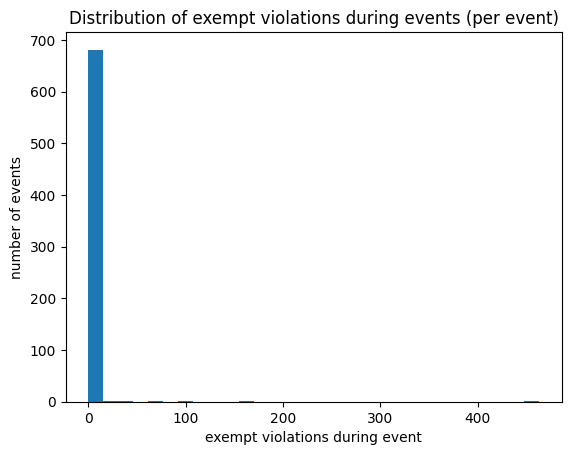

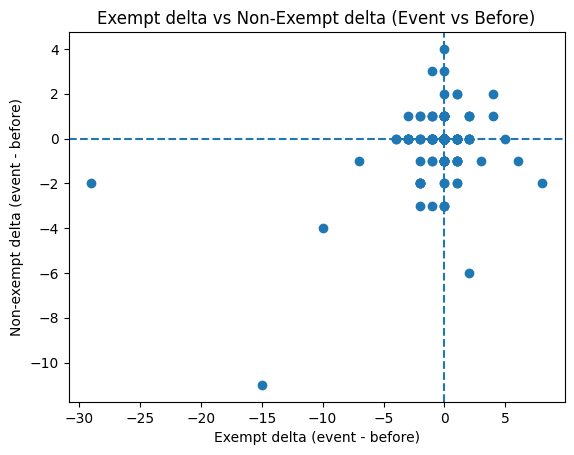

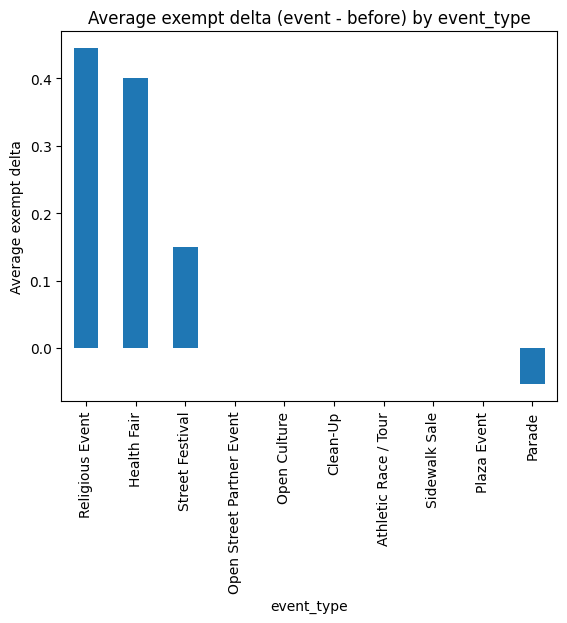

C:\Users\aisha\AppData\Local\Temp\ipykernel_23248\3399932777.py:266: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


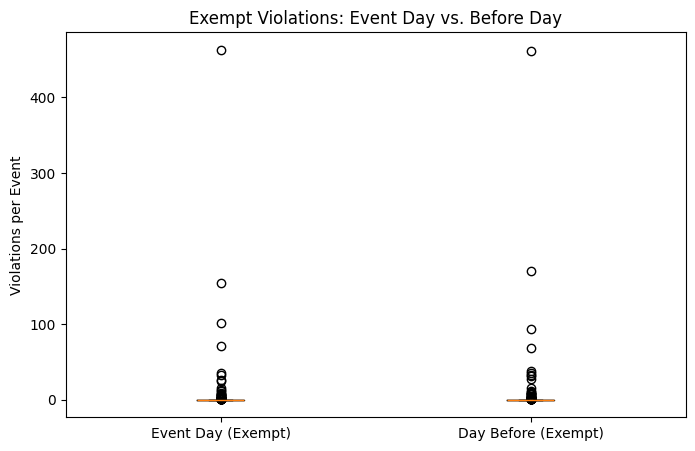

In [ ]:
# Dependencies:
# pip install pandas geopandas shapely matplotlib pyproj

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt

# ---------- UTILITY / PREPROCESSING FUNCTIONS ----------

def to_datetime_cols(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")
    return df

def make_geodf_from_latlon(df, lat_col="violation_latitude", lon_col="violation_longitude", crs="EPSG:4326"):
    # Create geometry column from lat/lon
    df = df.copy()
    if lat_col in df.columns and lon_col in df.columns:
        df["geometry"] = df.apply(lambda r: Point(float(r[lon_col]), float(r[lat_col])), axis=1)
        gdf = gpd.GeoDataFrame(df, geometry="geometry", crs=crs)
        return gdf
    else:
        raise KeyError(f"Missing lat/lon columns: {lat_col}, {lon_col}")

def event_point_gdf(events_df, lat_col="latitude", lon_col="longitude", crs="EPSG:4326"):
    df = events_df.copy()
    df["geometry"] = df.apply(lambda r: Point(float(r[lon_col]), float(r[lat_col])), axis=1)
    gdf = gpd.GeoDataFrame(df, geometry="geometry", crs=crs)
    return gdf

# ---------- MAIN PIPELINE FUNCTIONS ----------

def build_event_windows(events_df, before_days=1, after_days=1, use_same_weekday=False):
    """
    For each event row, produce a small DataFrame with event window and control windows.
    Returns a DataFrame with columns:
      event_id, event_start, event_end, ctrl_before_start, ctrl_before_end, ctrl_after_start, ctrl_after_end
    """
    rows = []
    for _, r in events_df.iterrows():
        event_id = r["event_id"]
        start = r["start_date_time"]
        end = r["end_date_time"]
        # If any are NaT, skip
        if pd.isna(start) or pd.isna(end):
            continue

        # Day before/after same hours
        before_start = start - timedelta(days=before_days)
        before_end = end - timedelta(days=before_days)
        after_start = start + timedelta(days=after_days)
        after_end = end + timedelta(days=after_days)

        # Optional: same weekday previous week control
        if use_same_weekday:
            before_start = start - timedelta(days=7)
            before_end = end - timedelta(days=7)

        rows.append({
            "event_id": event_id,
            "event_start": start,
            "event_end": end,
            "ctrl_before_start": before_start,
            "ctrl_before_end": before_end,
            "ctrl_after_start": after_start,
            "ctrl_after_end": after_end
        })

    ew = pd.DataFrame(rows)
    return ew

def filter_violations_spatial_temporal(violations_gdf, event_point, event_window_start, event_window_end, buffer_m=300):
    """
    Keep violations within buffer_m meters of event_point and whose first_occurrence or last_occurrence
    is within [event_window_start, event_window_end].
    - violations_gdf must be in EPSG:4326; will reproject to metric CRS for buffering.
    - event_point is a Shapely Point in same CRS (lon,lat).
    """
    # Reproject to a metric CRS for buffering (use UTM zone for NYC or global Mercator)
    # We'll use EPSG:3857 for simplicity (meters)
    v = violations_gdf.copy()
    v = v.to_crs(epsg=3857)
    # event_point geometry -> GeoSeries -> GeoDataFrame
    event_gdf = gpd.GeoDataFrame([{"geometry": event_point}], crs="EPSG:4326").to_crs(epsg=3857)
    buffer_geom = event_gdf.loc[0, "geometry"].buffer(buffer_m)

    # Spatial filter
    spatial_mask = v.geometry.within(buffer_geom)
    v_spatial = v.loc[spatial_mask].copy()

    # Temporal filter: check first_occurrence or last_occurrence columns
    time_mask = pd.Series(False, index=v_spatial.index)
    for tcol in ["first_occurrence", "last_occurrence"]:
        if tcol in v_spatial.columns:
            times = v_spatial[tcol]
            mask = (times >= event_window_start) & (times <= event_window_end)
            time_mask = time_mask | mask.fillna(False)

    v_final = v_spatial.loc[time_mask].copy()
    # Return back to original CRS (EPSG:4326)
    v_final = v_final.to_crs(epsg=4326)
    return v_final

def compute_event_counts_for_single_event(event_row, exempt_gdf, non_exempt_gdf, buffer_m=300):
    """
    Given one event (row containing event_id, latitude, longitude, event_start/event_end, etc),
    return a dict with counts: exempt_event_count, exempt_before_count, exempt_after_count,
    nonexempt_event_count, ...
    Also returns repeat-offender stats for exempt.
    """
    event_id = event_row["event_id"]
    event_start = event_row["event_start"]
    event_end = event_row["event_end"]
    before_start = event_row["ctrl_before_start"]
    before_end = event_row["ctrl_before_end"]
    after_start = event_row["ctrl_after_start"]
    after_end = event_row["ctrl_after_end"]

    # Build event point
    event_point = event_row["geometry"]

    # Spatial-temporal filters
    exempt_event = filter_violations_spatial_temporal(exempt_gdf, event_point, event_start, event_end, buffer_m)
    exempt_before = filter_violations_spatial_temporal(exempt_gdf, event_point, before_start, before_end, buffer_m)
    exempt_after = filter_violations_spatial_temporal(exempt_gdf, event_point, after_start, after_end, buffer_m)

    nonex_event = filter_violations_spatial_temporal(non_exempt_gdf, event_point, event_start, event_end, buffer_m)
    nonex_before = filter_violations_spatial_temporal(non_exempt_gdf, event_point, before_start, before_end, buffer_m)
    nonex_after = filter_violations_spatial_temporal(non_exempt_gdf, event_point, after_start, after_end, buffer_m)

    # Counts
    result = {
        "event_id": event_id,
        "exempt_event_count": len(exempt_event),
        "exempt_before_count": len(exempt_before),
        "exempt_after_count": len(exempt_after),
        "nonex_event_count": len(nonex_event),
        "nonex_before_count": len(nonex_before),
        "nonex_after_count": len(nonex_after),
    }

    # Repeat offender analysis (exempt)
    # Count violations per vehicle_id in each window
    def repeat_stats(gdf):
        if gdf.empty or "vehicle_id" not in gdf.columns:
            return {"repeat_vehicles": 0, "repeat_violations": 0, "unique_vehicles": 0}
        counts = gdf.groupby("vehicle_id").size()
        repeat_vehicles = (counts > 1).sum()
        repeat_violations = counts[counts > 1].sum()
        unique_vehicles = counts.size
        return {"repeat_vehicles": int(repeat_vehicles), "repeat_violations": int(repeat_violations), "unique_vehicles": int(unique_vehicles)}

    result.update({
        "exempt_event_repeat_vehicles": repeat_stats(exempt_event)["repeat_vehicles"],
        "exempt_event_repeat_violations": repeat_stats(exempt_event)["repeat_violations"],
        "exempt_event_unique_vehicles": repeat_stats(exempt_event)["unique_vehicles"],
        "exempt_before_repeat_vehicles": repeat_stats(exempt_before)["repeat_vehicles"],
        "exempt_after_repeat_vehicles": repeat_stats(exempt_after)["repeat_vehicles"],
    })

    # Optionally save ids of offending vehicles / top offenders
    result["exempt_event_top_vehicles"] = None
    if not exempt_event.empty:
        top = exempt_event.groupby("vehicle_id").size().sort_values(ascending=False).head(10)
        result["exempt_event_top_vehicles"] = top.to_dict()

    return result

# ---------- WRAPPER TO RUN FULL ANALYSIS OVER ALL EVENTS ----------

def run_full_event_analysis(exempt_df, nonex_df, events_df, buffer_m=300, use_same_weekday=False, event_gdf_crs="EPSG:4326"):
    # 1. Ensure date columns parsed
    exempt_df = to_datetime_cols(exempt_df, ["first_occurrence", "last_occurrence"])
    nonex_df = to_datetime_cols(nonex_df, ["first_occurrence", "last_occurrence"])
    events_df = to_datetime_cols(events_df, ["start_date_time", "end_date_time"])

    # 2. Convert violations to GeoDataFrames using their violation_latitude & violation_longitude
    exempt_gdf = make_geodf_from_latlon(exempt_df, lat_col="violation_latitude", lon_col="violation_longitude", crs=event_gdf_crs)
    nonex_gdf = make_geodf_from_latlon(nonex_df, lat_col="violation_latitude", lon_col="violation_longitude", crs=event_gdf_crs)

    # 3. Convert events to GeoDataFrame
    events_gdf = event_point_gdf(events_df, lat_col="latitude", lon_col="longitude", crs=event_gdf_crs)

    # 4. Build event windows
    event_windows = build_event_windows(events_gdf, before_days=1, after_days=1, use_same_weekday=use_same_weekday)
    # Join geometry & other event metadata into event_windows
    event_windows = event_windows.merge(events_gdf[["event_id", "geometry", "event_type", "street_closure_type", "event_name"]], on="event_id", how="left")

    # 5. Iterate events and compute counts
    results = []
    for _, ev in event_windows.iterrows():
        r = compute_event_counts_for_single_event(ev, exempt_gdf, nonex_gdf, buffer_m=buffer_m)
        # add metadata
        r["event_type"] = ev.get("event_type", None)
        r["street_closure_type"] = ev.get("street_closure_type", None)
        r["event_name"] = ev.get("event_name", None)
        results.append(r)

    results_df = pd.DataFrame(results)
    # Derived metrics
    results_df["exempt_delta_vs_before"] = results_df["exempt_event_count"] - results_df["exempt_before_count"]
    results_df["exempt_delta_vs_after"] = results_df["exempt_event_count"] - results_df["exempt_after_count"]
    results_df["nonex_delta_vs_before"] = results_df["nonex_event_count"] - results_df["nonex_before_count"]
    results_df["nonex_delta_vs_after"] = results_df["nonex_event_count"] - results_df["nonex_after_count"]

    # Percent changes (handle divide by zero)
    results_df["exempt_pct_change_vs_before"] = np.where(results_df["exempt_before_count"] > 0,
                                                        (results_df["exempt_event_count"] - results_df["exempt_before_count"]) / results_df["exempt_before_count"],
                                                        np.nan)
    results_df["nonex_pct_change_vs_before"] = np.where(results_df["nonex_before_count"] > 0,
                                                        (results_df["nonex_event_count"] - results_df["nonex_before_count"]) / results_df["nonex_before_count"],
                                                        np.nan)

    return results_df

# ---------- VISUALIZATION & SUMMARY FUNCTIONS ----------

def summarize_and_plot(results_df, top_n_eventtypes=10):
    # Basic aggregate summaries
    summary = {
        "n_events": len(results_df),
        "mean_exempt_event": results_df["exempt_event_count"].mean(),
        "median_exempt_event": results_df["exempt_event_count"].median(),
        "mean_exempt_delta_vs_before": results_df["exempt_delta_vs_before"].mean(),
        "mean_nonex_delta_vs_before": results_df["nonex_delta_vs_before"].mean(),
        "mean_exempt_repeat_vehicles": results_df["exempt_event_repeat_vehicles"].mean(),
    }
    print("SUMMARY:")
    for k, v in summary.items():
        print(f"  {k}: {v}")

    # Histogram: distribution of exempt_event_count
    plt.figure()
    plt.hist(results_df["exempt_event_count"].dropna(), bins=30)
    plt.title("Distribution of exempt violations during events (per event)")
    plt.xlabel("exempt violations during event")
    plt.ylabel("number of events")
    plt.show()

    # Scatter: exempt delta vs nonex delta
    plt.figure()
    plt.scatter(results_df["exempt_delta_vs_before"], results_df["nonex_delta_vs_before"])
    plt.axhline(0, linestyle="--")
    plt.axvline(0, linestyle="--")
    plt.title("Exempt delta vs Non-Exempt delta (Event vs Before)")
    plt.xlabel("Exempt delta (event - before)")
    plt.ylabel("Non-exempt delta (event - before)")
    plt.show()

    # Bar by event type (top event types)
    if "event_type" in results_df.columns:
        types = results_df.groupby("event_type")["exempt_delta_vs_before"].mean().sort_values(ascending=False).head(top_n_eventtypes)
        plt.figure()
        types.plot(kind="bar")
        plt.title("Average exempt delta (event - before) by event_type")
        plt.ylabel("Average exempt delta")
        plt.xlabel("event_type")
        plt.show()
    
    # 2. Event vs Control (Before Day) – Boxplot
    plt.figure(figsize=(8,5))
    plt.boxplot(
        [results_df["exempt_event_count"], results_df["exempt_before_count"]],
        labels=["Event Day (Exempt)", "Day Before (Exempt)"]
    )
    plt.title("Exempt Violations: Event Day vs. Before Day")
    plt.ylabel("Violations per Event")
    plt.show()

    return summary

# ---------- EXAMPLE: Run full pipeline (wrapped to not execute accidentally) ----------
if __name__ == "__main__":
    # If running interactively, remove the guard and call run_full_event_analysis with your real DataFrames:
    results = run_full_event_analysis(ACE_CBD_exempt_violations_2024, ACE_CBD_non_exempt_violations_2024, new_CBD_unique_events_geocoded_2024, buffer_m=300)
    summary = summarize_and_plot(results)
    pass

# ---------- NOTES & EXTENSIONS ----------
# 1) Buffer size (buffer_m): start with 200-400 meters; adjust based on spatial density.
# 2) Time windows: code currently uses exact event start/end hours. If you'd like to extend to +/- hours (e.g., 2 hours before/after),
#    modify build_event_windows to expand event_start/event_end by desired timedelta.
# 3) Day-of-week robustness: set use_same_weekday=True when calling run_full_event_analysis to compare event to same weekday prior week.
# 4) If event geocoding is noisy, you can match by bus_route_id if events include textual street segments; that requires mapping bus stops to street segments.
# 5) Save results: results_df.to_csv("event_violation_analysis_results.csv", index=False)

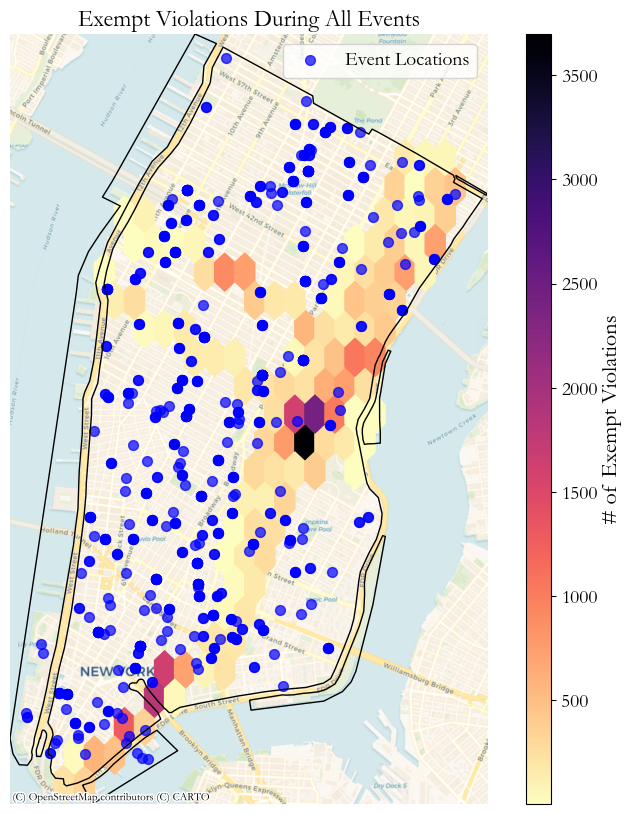

In [32]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import pandas as pd

def plot_event_violation_heatmap(exempt_gdf, event_windows_df, cbd_shapefile, title="Exempt Violations During All Events"):
    """
    Plots a heatmap of exempt violations only during event windows, clipped to the CBD,
    and overlays event points.
    
    Parameters:
        exempt_gdf: GeoDataFrame of violations with 'first_occurrence' column
        event_windows_df: DataFrame with 'event_start', 'event_end' (datetime), 'geometry' columns
        cbd_shapefile: path to the CBD shapefile
        title: plot title
    """
    # Load CBD boundary
    cbd_boundary = gpd.read_file(cbd_shapefile)
    
    # Ensure CRS matches
    exempt_gdf = exempt_gdf.set_crs(epsg=4326, allow_override=True)
    cbd_boundary = cbd_boundary.to_crs(exempt_gdf.crs)
    
    # Ensure datetime column
    exempt_gdf["first_occurrence"] = pd.to_datetime(exempt_gdf["first_occurrence"], errors="coerce")
    
    # Filter violations inside any event window
    mask = pd.Series(False, index=exempt_gdf.index)
    for _, ev in event_windows_df.iterrows():
        if pd.notnull(ev.get("event_start")) and pd.notnull(ev.get("event_end")):
            mask |= (exempt_gdf["first_occurrence"] >= ev["event_start"]) & \
                    (exempt_gdf["first_occurrence"] <= ev["event_end"])
    
    event_violations = exempt_gdf.loc[mask].copy()
    
    # Clip to CBD
    cbd_event_violations = gpd.clip(event_violations, cbd_boundary)
    
    # Convert event points to GeoDataFrame and clip to CBD
    events_gdf = gpd.GeoDataFrame(event_windows_df, geometry="geometry", crs="EPSG:4326")
    events_gdf = gpd.clip(events_gdf, cbd_boundary)
    
    # Reproject for basemap
    cbd_event_violations = cbd_event_violations.to_crs(epsg=3857)
    events_gdf = events_gdf.to_crs(epsg=3857)
    cbd_boundary = cbd_boundary.to_crs(epsg=3857)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    if not cbd_event_violations.empty:
        x = cbd_event_violations.geometry.x
        y = cbd_event_violations.geometry.y
        hb = ax.hexbin(x, y, gridsize=20, cmap="magma_r", mincnt=1)
        cb = fig.colorbar(hb, ax=ax, aspect=30)
        cb.set_label("# of Exempt Violations", fontsize=16)
    else:
        print("No violations found during event windows inside the CBD.")
    
    # Overlay CBD boundary
    cbd_boundary.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
    
    # Overlay event points
    if not events_gdf.empty:
        events_gdf.plot(ax=ax, color="blue", markersize=50, alpha=0.7, label="Event Locations")
        ax.legend()
    
    # Set axis limits to CBD bounds
    ax.set_xlim(cbd_boundary.total_bounds[0], cbd_boundary.total_bounds[2])
    ax.set_ylim(cbd_boundary.total_bounds[1], cbd_boundary.total_bounds[3])
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)
    
    ax.set_title(title)
    ax.axis("off")
    plt.show()

CBD_SHAPEFILE = os.path.join(DATA_DIR_RAW, "central_business_district.shp")

# Convert violations to GeoDataFrame
exempt_gdf = make_geodf_from_latlon(
    ACE_CBD_exempt_violations_2024,
    lat_col="violation_latitude",
    lon_col="violation_longitude"
)

# Build event windows
event_windows = build_event_windows(new_CBD_unique_events_geocoded_2024)
event_windows = event_windows.merge(
    event_point_gdf(new_CBD_unique_events_geocoded_2024)[["event_id", "geometry"]],
    on="event_id",
    how="left"
)

# Plot heatmap with event points
plot_event_violation_heatmap(exempt_gdf, event_windows, CBD_SHAPEFILE)


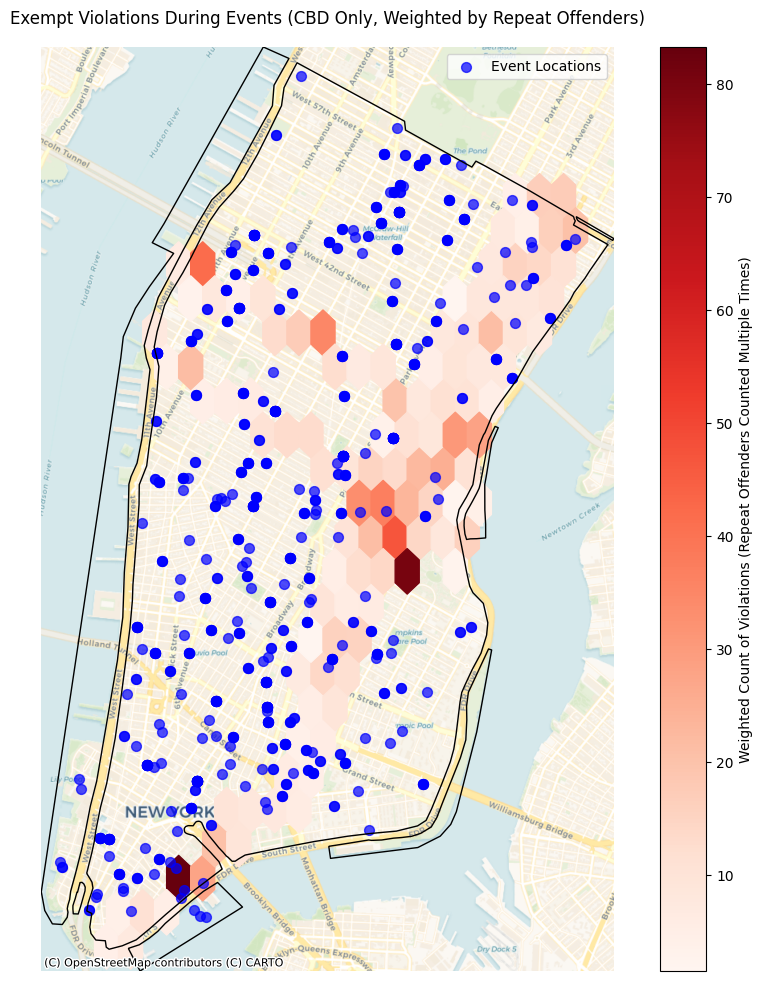

In [25]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import pandas as pd

def plot_event_violation_heatmap_with_events(exempt_gdf, event_windows_df, cbd_shapefile, title="Exempt Violations During Events (CBD Only, Weighted by Repeat Offenders)"):
    """
    Plots a heatmap of exempt violations during event windows, clipped to the CBD,
    weighted by repeat offenders, and overlays event locations.
    """
    # Load CBD boundary
    cbd_boundary = gpd.read_file(cbd_shapefile)
    
    # Ensure CRS matches
    exempt_gdf = exempt_gdf.set_crs(epsg=4326, allow_override=True)
    cbd_boundary = cbd_boundary.to_crs(exempt_gdf.crs)
    
    # Ensure datetime column
    exempt_gdf["first_occurrence"] = pd.to_datetime(exempt_gdf["first_occurrence"], errors="coerce")
    
    # Filter violations within event windows
    mask = pd.Series(False, index=exempt_gdf.index)
    for _, ev in event_windows_df.iterrows():
        if pd.notnull(ev.get("event_start")) and pd.notnull(ev.get("event_end")):
            mask |= (exempt_gdf["first_occurrence"] >= ev["event_start"]) & \
                    (exempt_gdf["first_occurrence"] <= ev["event_end"])
    
    event_violations = exempt_gdf.loc[mask].copy()
    
    if event_violations.empty:
        print("No violations found during event windows inside the CBD.")
        return
    
    # Count repeat violations per vehicle
    if "vehicle_id" in event_violations.columns:
        event_violations["weight"] = event_violations.groupby("vehicle_id")["vehicle_id"].transform("count")
    else:
        event_violations["weight"] = 1
    
    # Clip violations to CBD
    cbd_event_violations = gpd.clip(event_violations, cbd_boundary)
    
    # Convert event points to GeoDataFrame and clip to CBD
    events_gdf = gpd.GeoDataFrame(event_windows_df, geometry="geometry", crs="EPSG:4326")
    events_gdf = gpd.clip(events_gdf, cbd_boundary)
    
    # Reproject for basemap
    cbd_event_violations = cbd_event_violations.to_crs(epsg=3857)
    events_gdf = events_gdf.to_crs(epsg=3857)
    cbd_boundary = cbd_boundary.to_crs(epsg=3857)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 12))
    x = cbd_event_violations.geometry.x
    y = cbd_event_violations.geometry.y
    weights = cbd_event_violations["weight"]
    
    hb = ax.hexbin(x, y, C=weights, gridsize=20, cmap="Reds", mincnt=1)
    
    # Overlay CBD boundary
    cbd_boundary.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
    
    # Overlay event points
    events_gdf.plot(ax=ax, color="blue", markersize=50, alpha=0.7, label="Event Locations")
    
    # Set axis limits to CBD bounds
    ax.set_xlim(cbd_boundary.total_bounds[0], cbd_boundary.total_bounds[2])
    ax.set_ylim(cbd_boundary.total_bounds[1], cbd_boundary.total_bounds[3])
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)
    
    # Colorbar & title
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label("Weighted Count of Violations (Repeat Offenders Counted Multiple Times)")
    ax.set_title(title)
    ax.axis("off")
    ax.legend()
    plt.show()

CBD_SHAPEFILE = os.path.join(DATA_DIR_RAW, "central_business_district.shp")

# Convert violations to GeoDataFrame
exempt_gdf = make_geodf_from_latlon(
    ACE_CBD_exempt_violations_2024,
    lat_col="violation_latitude",
    lon_col="violation_longitude"
)

# Build event windows
event_windows = build_event_windows(new_CBD_unique_events_geocoded_2024)
event_windows = event_windows.merge(
    event_point_gdf(new_CBD_unique_events_geocoded_2024)[["event_id", "geometry"]],
    on="event_id",
    how="left"
)

# Plot heatmap weighted by repeat offenders with event points
plot_event_violation_heatmap_with_events(exempt_gdf, event_windows, CBD_SHAPEFILE)
